In [226]:
import re
import matplotlib.pyplot as plt
import string
import numpy as np
import pandas as pd
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
import spacy
import pickle

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras

print("All Imported")

All Imported


In [227]:
df = pd.read_csv('text_emotion.csv')

In [228]:
df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


### Total number of Tweets

In [229]:
len(df)

40000

### Finding the number of values for each emotion

In [230]:
df.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

### Converting emotions to their related sentiment

In [231]:
conditions = [
    (df['sentiment'].isin( ['empty','sadness','worry','hate','boredom','anger',])),
    (df['sentiment'].isin( ['enthusiasm','love','fun','happiness','relief'])),
    (df['sentiment'].isin( ['surprise','neutral',]))
    ]

# create a list of the values we want to assign for each condition
values = ['negative', 'positive', 'neutral']

# create a new column for three class sentiments
df['new_sentiment'] = np.select(conditions, values)

### We are only interested in new_sentiment and content columns

In [232]:
df = df[['new_sentiment','content']]

In [233]:
df.new_sentiment.value_counts()

negative    16063
positive    13112
neutral     10825
Name: new_sentiment, dtype: int64

### Finding the mean of length of tweets before cleaning

In [234]:
df['pre_clean_len'] = [len(t) for t in df.content]
print(df['pre_clean_len'].mean())

73.40555


ploting pre_clean_len with box plot, so that we can see the overall distribution of length of strings in each entry.

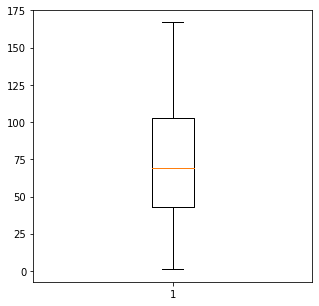

In [235]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

# Cleaning and Preprocessing Section

#### There is no null values before cleaning

In [236]:
df["content"].isnull().sum()


0

### As the first step, We witnessed that some tweets consists html tags so we need to perform html decoding

In [237]:
df.content[307]

'@jhicks  youre diabetic?   so is my dad.  &amp; i might be too, not sure.  are you still allowed to eat sugar throughout the day?'

In [238]:
from html import unescape
df.content = df.content.apply(unescape)

In [239]:
df.content[307]

'@jhicks  youre diabetic?   so is my dad.  & i might be too, not sure.  are you still allowed to eat sugar throughout the day?'

### The next steps for data cleaning will be:
- Removing URLs from the tweets
- Removing emails
- Removing new lines characters
- Removing single quotes
- Removing all punctuation signs
- Lowercase all text
- tokenizing text
- Converting list of texts to Numpy array

In [240]:
def clean_data(data):
    
    #Removing URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    
    # Removing Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Removing new line characters
    data = re.sub('\s+', ' ', data)

    # Removing single quotes
    data = re.sub("\'", "", data)

    return data

In [241]:
tweet_list = []
#Splitting to list
data_to_list = df['content'].values.tolist()
for i in range(len(data_to_list)):
    tweet_list.append(clean_data(data_to_list[i]))
list(tweet_list[:5])

['i know i was listenin to bad habit earlier and i started freakin at his part =[',
 'Layin n bed with a headache ughhhh...waitin on your call...',
 'Funeral ceremony...gloomy friday...',
 'wants to hang out with friends SOON!',
 'We want to trade with someone who has Houston tickets, but no one will.']

### Punctuation are still parts of tweets

In [242]:
tweet_list[0]

'i know i was listenin to bad habit earlier and i started freakin at his part =['

#### In the next step, tweets are tokenized and punctuation are removed(by assigning deacc=True)

In [243]:
def token(tweets):
    for tweet in tweets:
        yield(gensim.utils.simple_preprocess(str(tweet), deacc=True)) 
        
data_words = list(token(tweet_list))
print(data_words[:10])

[['know', 'was', 'listenin', 'to', 'bad', 'habit', 'earlier', 'and', 'started', 'freakin', 'at', 'his', 'part'], ['layin', 'bed', 'with', 'headache', 'ughhhh', 'waitin', 'on', 'your', 'call'], ['funeral', 'ceremony', 'gloomy', 'friday'], ['wants', 'to', 'hang', 'out', 'with', 'friends', 'soon'], ['we', 'want', 'to', 'trade', 'with', 'someone', 'who', 'has', 'houston', 'tickets', 'but', 'no', 'one', 'will'], ['re', 'pinging', 'why', 'didnt', 'you', 'go', 'to', 'prom', 'bc', 'my', 'bf', 'didnt', 'like', 'my', 'friends'], ['should', 'be', 'sleep', 'but', 'im', 'not', 'thinking', 'about', 'an', 'old', 'friend', 'who', 'want', 'but', 'hes', 'married', 'now', 'damn', 'he', 'wants', 'me', 'scandalous'], ['hmmm', 'is', 'down'], ['charlene', 'my', 'love', 'miss', 'you'], ['im', 'sorry', 'at', 'least', 'its', 'friday']]


### We again need to convert tokens to tweets

In [244]:
def detoken(text):
    return TreebankWordDetokenizer().detokenize(text)

In [245]:
data = []
for i in range(len(data_words)):
    data.append(detoken(data_words[i]))
print(data[:5])

['know was listenin to bad habit earlier and started freakin at his part', 'layin bed with headache ughhhh waitin on your call', 'funeral ceremony gloomy friday', 'wants to hang out with friends soon', 'we want to trade with someone who has houston tickets but no one will']


### We create a new column from the list to do further cleaning and analysis

In [246]:
data = np.array(data)
df['content2'] =[d for d in data]

### evaluating tweets before removing stop words

#### Checking the occurences of words in each sentiment using wordcloud

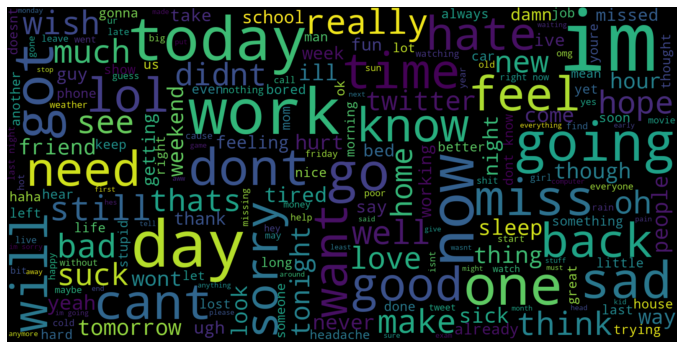

In [247]:
neg_tweets = df[df.new_sentiment == 'negative']
neg_string = []
for t in neg_tweets.content2:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

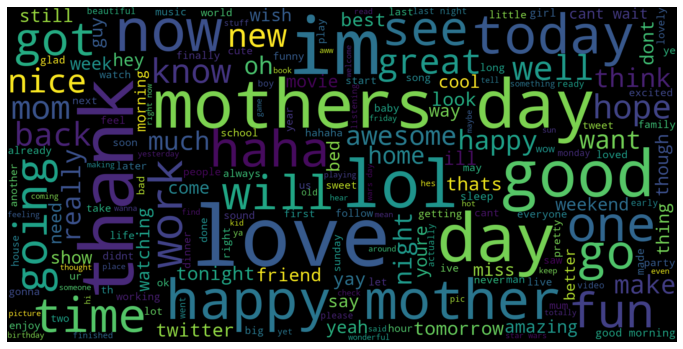

In [248]:
pos_tweets = df[df.new_sentiment == 'positive']
pos_string = []
for t in pos_tweets.content2:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

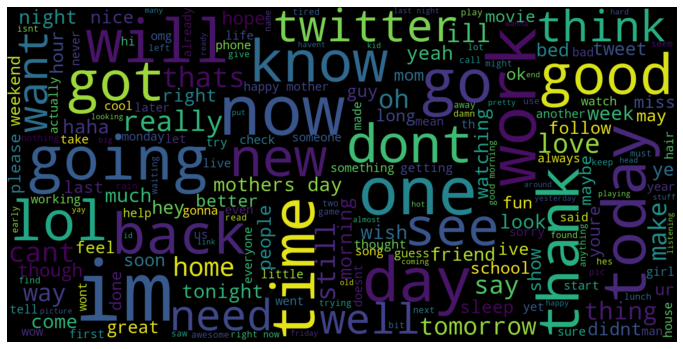

In [249]:
neu_tweets = df[df.new_sentiment == 'neutral']
neu_string = []
for t in neu_tweets.content2:
    neu_string.append(t)
neu_string = pd.Series(neu_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neu_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Checking why love is in negative sentiment and we see that they are used in a negative context

In [250]:
for t in neg_tweets.content2[:200]:
    if 'love' in t:
        print(t)

charlene my love miss you
love those itsakey usb sticks we only have the gb in australia
early happy day of birth in case dont make it very tired from therapy today just taking my medicine misshu love ya
but yeah im sad about my ravenclaw account love that account to bits
my roommate loves to ignore me
im contacting paws philippines so can find tiger new owner im so sad love my dog soo much


### Total number of words in our tweets

In [251]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(df.content2)

CountVectorizer()

In [252]:
len(cvec.get_feature_names())


29231

### Top words and their occurences in each category

In [253]:
neg_matrix = cvec.transform(df[df.new_sentiment =='negative'].content2)
pos_matrix = cvec.transform(df[df.new_sentiment =='positive'].content2)
neu_matrix = cvec.transform(df[df.new_sentiment =='neutral'].content2)

neg_tf = np.sum(neg_matrix,axis=0)
pos_tf = np.sum(pos_matrix,axis=0)
neu_tf = np.sum(neu_matrix,axis=0)

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
neu = np.squeeze(np.asarray(neu_tf))

word_freq_df = pd.DataFrame([neg,pos, neu],columns=cvec.get_feature_names()).transpose()

In [254]:
word_freq_df.columns = ['negative', 'positive','neutral']
word_freq_df['total'] = word_freq_df['negative'] + word_freq_df['positive'] + word_freq_df['neutral']
word_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,neutral,total
to,6347,4590,3442,14379
the,5317,4511,3144,12972
my,3882,2548,1643,8073
and,3178,2564,1721,7463
you,2427,2835,1828,7090
it,2548,1965,1411,5924
is,2554,1729,1417,5700
in,2367,1660,1405,5432
for,1985,2022,1284,5291
of,1900,1538,1073,4511


### Removing stop words 

In [255]:
nltk.download('punkt')
def identify_tokens(row):
    review = row['content2']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

df['words'] = df.apply(identify_tokens, axis=1)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\salma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [256]:
from nltk.stem import PorterStemmer
stemming = PorterStemmer()
def stem_list(row):
    my_list = row['words']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

df['stemmed_words'] = df.apply(stem_list, axis=1)

#### whitelist the negative words like not and no

In [257]:
nltk.download('stopwords')
stops = set(stopwords.words("english"))                  
def remove_stops(row):
    my_list = row['stemmed_words']
    whitelist = ["n't", "not", "no"]
    meaningful_words = [w for w in my_list if not w in stops  or w in whitelist]
    return (meaningful_words)
df['stem_meaningful'] = df.apply(remove_stops, axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\salma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [258]:
stops = set(stopwords.words("english"))                  

def remove_stops(row):
    my_list = row['stemmed_words']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

df['stem_meaningful'] = df.apply(remove_stops, axis=1)

In [259]:
def rejoin_words(row):
    my_list = row['stem_meaningful']
    joined_words = ( " ".join(my_list))
    return joined_words

df['content2'] = df.apply(rejoin_words, axis=1)

### Checking the number and frequency of words after removing stop words

In [260]:
cvec = CountVectorizer()
cvec.fit(df.content2)

CountVectorizer()

In [261]:
len(cvec.get_feature_names())

22627

In [262]:
neg_matrix = cvec.transform(df[df.new_sentiment =='negative'].content2)
pos_matrix = cvec.transform(df[df.new_sentiment =='positive'].content2)
neu_matrix = cvec.transform(df[df.new_sentiment =='neutral'].content2)

neg_tf = np.sum(neg_matrix,axis=0)
pos_tf = np.sum(pos_matrix,axis=0)
neu_tf = np.sum(neu_matrix,axis=0)

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
neu = np.squeeze(np.asarray(neu_tf))

word_freq_df = pd.DataFrame([neg,pos, neu],columns=cvec.get_feature_names()).transpose()

In [263]:
word_freq_df.columns = ['negative', 'positive','neutral']
word_freq_df['total'] = word_freq_df['negative'] + word_freq_df['positive'] + word_freq_df['neutral']
word_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,neutral,total
im,2294,1313,878,4485
day,1147,1898,647,3692
go,1563,1007,829,3399
get,1313,757,653,2723
wa,1099,961,604,2664
good,672,1201,460,2333
thi,1085,681,522,2288
work,1132,538,538,2208
love,390,1506,232,2128
like,911,710,464,2085


We see that stop words are removed and stemmed version of tweets are showing

### Visualization of Tokens that are used for analysis after removing stop words

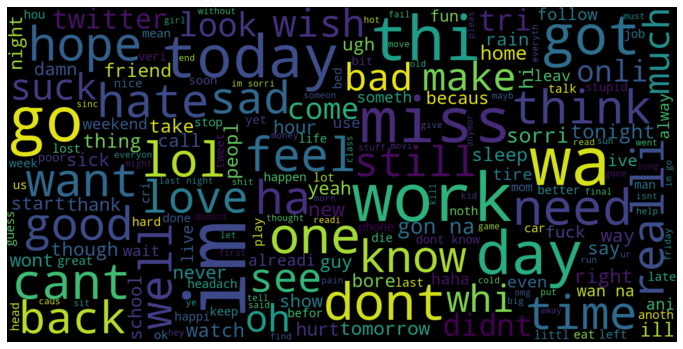

In [264]:
neg_tweets = df[df.new_sentiment == 'negative']
neg_string = []
for t in neg_tweets.content2:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

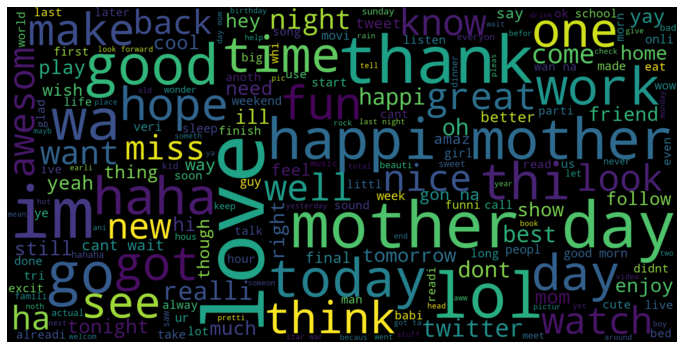

In [265]:
pos_tweets = df[df.new_sentiment == 'positive']
pos_string = []
for t in pos_tweets.content2:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

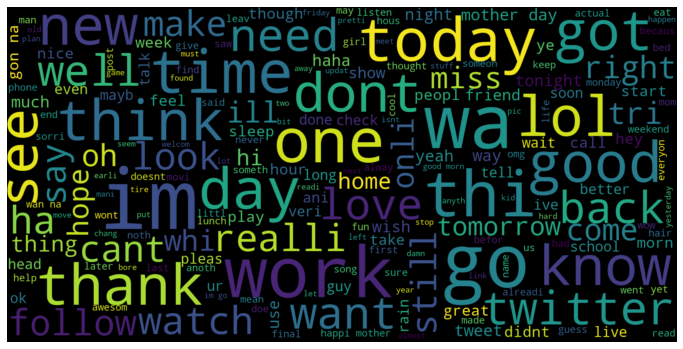

In [266]:
neu_tweets = df[df.new_sentiment == 'neutral']
neu_string = []
for t in neu_tweets.content2:
    neu_string.append(t)
neu_string = pd.Series(neu_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neu_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### After all cleaning and preprocessing performed, some contents are empty, so we need to remove them

In [267]:
len(df[df.content2==''])

209

In [268]:
df = df.drop(df[df.content2==''].index)

### Convert sentiments to numbers to use in algorithms

In [269]:
conditions = [
    (df['new_sentiment'].isin( ['empty','sadness','worry','hate','boredom','anger',])),
    (df['new_sentiment'].isin( ['enthusiasm','love','fun','happiness','relief'])),
    (df['new_sentiment'].isin( ['surprise','neutral',]))
    ]

# create a list of the values we want to assign for each condition
# values = ['negative', 'positive', 'neutral']
values = [0, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments
df['label'] = np.select(conditions, values)
df['text']=df['content2']
df=df[['text','label']]

# display updated DataFrame
df.head()

,text,label
0,know wa listenin bad habit earlier start freak...,0
1,layin bed headach ughhhh waitin call,0
2,funer ceremoni gloomi friday,0
3,want hang friend soon,0
4,want trade someon ha houston ticket one,2


## Neural network

In [98]:
dataset=df

In [99]:
train_dataset_first, test_dataset_first =train_test_split(dataset,test_size=0.3, random_state=2000)

In [100]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_dataset_first.text, train_dataset_first.label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_dataset_first.text, test_dataset_first.label))

In [101]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [102]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [103]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'im', 'day', 'go', 'get', 'wa', 'thi', 'good', 'work',
       'love', 'like', 'got', 'dont', 'today', 'time', 'one', 'thank',
       'cant', 'happi'], dtype='<U12')

In [104]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## start working with models

## relu

In [105]:
modelR = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [106]:
modelR.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [107]:
historyR = modelR.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 33s 37ms/step - loss: 0.6913 - accuracy: 0.7258 - val_loss: 0.5491 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5755 - accuracy: 0.7310 - val_loss: 0.5385 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5627 - accuracy: 0.7325 - val_loss: 0.5407 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5584 - accuracy: 0.7303 - val_loss: 0.5396 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5496 - accuracy: 0.7341 - val_loss: 0.5368 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5548 - accuracy: 0.7267 - val_loss: 0.5382 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 12s 27ms/step - loss: 0.5522 - accuracy: 0.7267 - val_loss: 0.5352 - val_accuracy:

In [108]:
test_loss, test_acc = modelR.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.5484 - accuracy: 0.7336
Test Loss: 0.5483628511428833
Test Accuracy: 0.733623743057251


In [89]:
from sklearn.metrics import classification_report
predict=np.around(modelR.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [97]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelR.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]
[0 0]


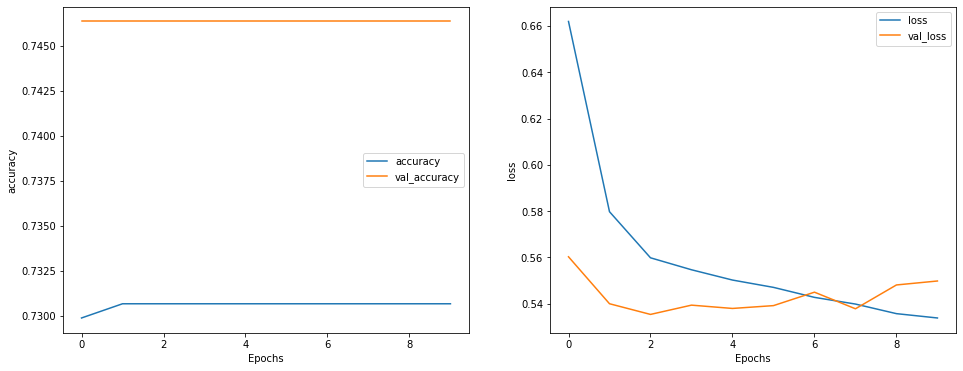

In [91]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyR, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyR, 'loss')

## sigmoid

In [92]:
modelS = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [93]:
modelS.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [94]:
historyS = modelS.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 37s 38ms/step - loss: 0.7159 - accuracy: 0.6983 - val_loss: 0.5517 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5785 - accuracy: 0.7332 - val_loss: 0.5467 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 12s 27ms/step - loss: 0.5661 - accuracy: 0.7367 - val_loss: 0.5418 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 12s 27ms/step - loss: 0.5585 - accuracy: 0.7411 - val_loss: 0.5352 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5490 - accuracy: 0.7395 - val_loss: 0.5351 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 12s 27ms/step - loss: 0.5497 - accuracy: 0.7402 - val_loss: 0.5344 - val_accuracy: 0.7479
Epoch 7/10
436/436 [==============================] - 12s 26ms/step - loss: 0.5442 - accuracy: 0.7436 - val_loss: 0.5353 - val_accuracy:

In [95]:
test_loss, test_acc = modelS.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 7ms/step - loss: 0.5484 - accuracy: 0.7336
Test Loss: 0.5483794808387756
Test Accuracy: 0.733623743057251


In [96]:
from sklearn.metrics import classification_report
predict=np.around(modelS.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [98]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelS.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


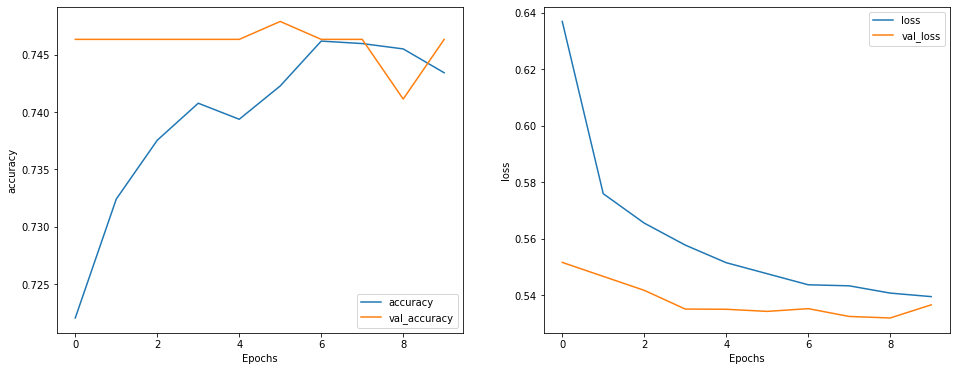

In [99]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyS, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyS, 'loss')

## tanh

In [109]:
modelT = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [110]:
modelT.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [111]:
historyT = modelT.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 36s 38ms/step - loss: 0.6981 - accuracy: 0.7210 - val_loss: 0.5548 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 12s 27ms/step - loss: 0.5751 - accuracy: 0.7305 - val_loss: 0.5353 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5548 - accuracy: 0.7338 - val_loss: 0.5369 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5473 - accuracy: 0.7297 - val_loss: 0.5324 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 12s 27ms/step - loss: 0.5338 - accuracy: 0.7398 - val_loss: 0.5314 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5364 - accuracy: 0.7367 - val_loss: 0.5400 - val_accuracy: 0.7448
Epoch 7/10
436/436 [==============================] - 12s 26ms/step - loss: 0.5215 - accuracy: 0.7467 - val_loss: 0.5418 - val_accuracy:

In [112]:
test_loss, test_acc = modelT.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.5637 - accuracy: 0.7252
Test Loss: 0.5637282729148865
Test Accuracy: 0.7251633405685425


In [119]:
from sklearn.metrics import classification_report
predict=np.around(modelT.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7531    0.9300    0.8323      8758
           2     0.4541    0.1604    0.2370      3180

    accuracy                         0.7250     11938
   macro avg     0.6036    0.5452    0.5347     11938
weighted avg     0.6735    0.7250    0.6737     11938



In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelT.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


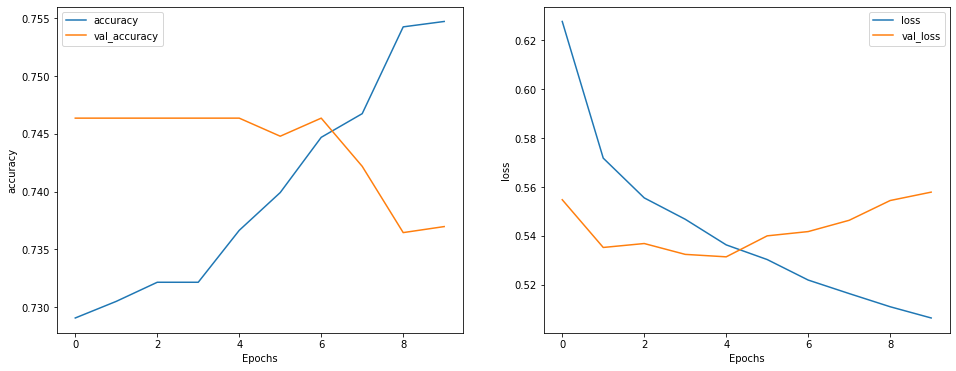

In [114]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyT, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyT, 'loss')

## Add dropout layer after embeding layer to reduce overfitting

## Simple using of RNN

### relu

In [120]:
modelRD = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [121]:
modelRD.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [122]:
historyRD = modelRD.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 38s 38ms/step - loss: 0.7302 - accuracy: 0.7227 - val_loss: 0.5630 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5923 - accuracy: 0.7281 - val_loss: 0.5478 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 12s 27ms/step - loss: 0.5760 - accuracy: 0.7330 - val_loss: 0.5564 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 12s 27ms/step - loss: 0.5756 - accuracy: 0.7285 - val_loss: 0.5528 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5741 - accuracy: 0.7284 - val_loss: 0.5476 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 12s 26ms/step - loss: 0.5717 - accuracy: 0.7306 - val_loss: 0.5504 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 12s 27ms/step - loss: 0.5693 - accuracy: 0.7309 - val_loss: 0.5440 - val_accuracy:

In [123]:
test_loss, test_acc = modelRD.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 7ms/step - loss: 0.5574 - accuracy: 0.7336
Test Loss: 0.5573625564575195
Test Accuracy: 0.733623743057251


In [124]:
# np.around(model.predict(test_dataset_first.text),decimals=0).argmax(axis=1)

In [125]:
# np.array(test_dataset_first.label)

In [126]:
from sklearn.metrics import classification_report
predict=np.around(modelRD.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [127]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelRD.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[[7.0911515e-01 4.5904249e-04 2.9042587e-01]]


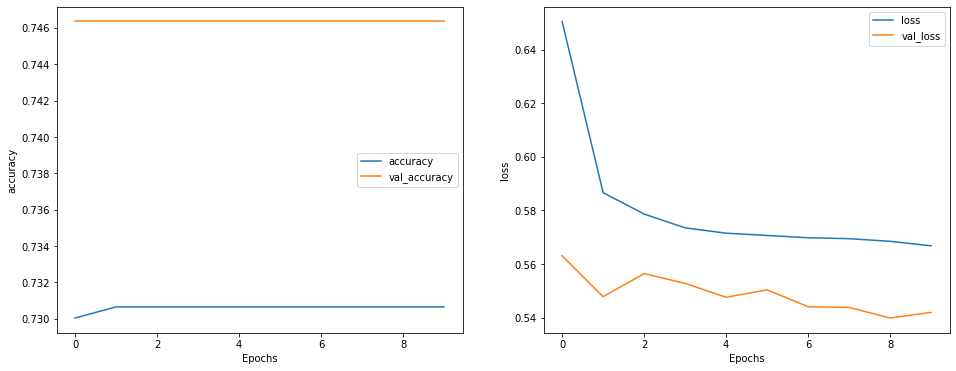

In [128]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyRD, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyRD, 'loss')

### sigmoid

In [129]:
modelSD = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [130]:
modelSD.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [131]:
historySD = modelSD.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 36s 37ms/step - loss: 0.7352 - accuracy: 0.6943 - val_loss: 0.5642 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5825 - accuracy: 0.7317 - val_loss: 0.5457 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5692 - accuracy: 0.7349 - val_loss: 0.5409 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5653 - accuracy: 0.7343 - val_loss: 0.5390 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5615 - accuracy: 0.7340 - val_loss: 0.5331 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5582 - accuracy: 0.7356 - val_loss: 0.5346 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5582 - accuracy: 0.7349 - val_loss: 0.5299 - val_accuracy:

In [132]:
test_loss, test_acc = modelSD.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.5449 - accuracy: 0.7336
Test Loss: 0.5448563694953918
Test Accuracy: 0.733623743057251


In [133]:
from sklearn.metrics import classification_report
predict=np.around(modelSD.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [134]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelSD.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[[6.8606329e-01 6.4431364e-04 3.1329235e-01]]


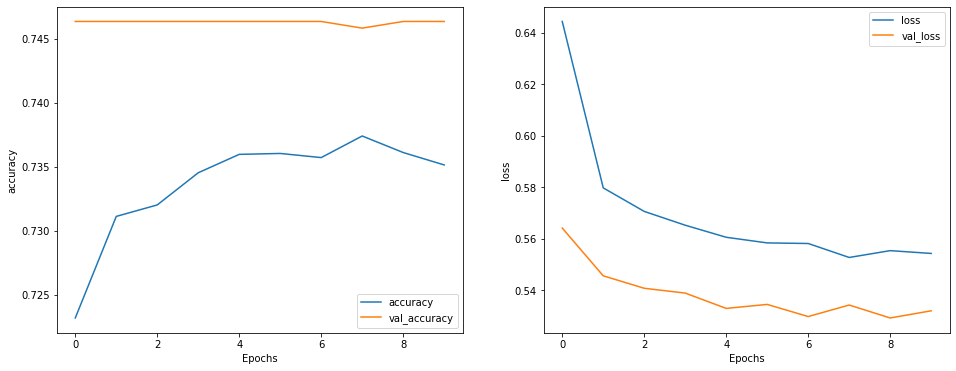

In [135]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historySD, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historySD, 'loss')

### tanh

In [136]:
modelTD = tf.keras.Sequential([
    encoder,
   tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [137]:
modelTD.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [138]:
historyTD = modelTD.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 37s 38ms/step - loss: 0.6735 - accuracy: 0.7038 - val_loss: 0.5653 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5882 - accuracy: 0.7287 - val_loss: 0.5433 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5688 - accuracy: 0.7311 - val_loss: 0.5367 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5621 - accuracy: 0.7274 - val_loss: 0.5346 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5534 - accuracy: 0.7316 - val_loss: 0.5329 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5490 - accuracy: 0.7338 - val_loss: 0.5335 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5478 - accuracy: 0.7333 - val_loss: 0.5275 - val_accuracy:

In [139]:
test_loss, test_acc = modelTD.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 7ms/step - loss: 0.5403 - accuracy: 0.7345
Test Loss: 0.5402747988700867
Test Accuracy: 0.7344613671302795


In [147]:
from sklearn.metrics import classification_report
predict=np.around(modelTD.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7354    0.9965    0.8463      8758
           2     0.5634    0.0126    0.0246      3180

    accuracy                         0.7344     11938
   macro avg     0.6494    0.5045    0.4354     11938
weighted avg     0.6896    0.7344    0.6274     11938



In [140]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelTD.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[[7.3071474e-01 2.3279760e-04 2.6905248e-01]]


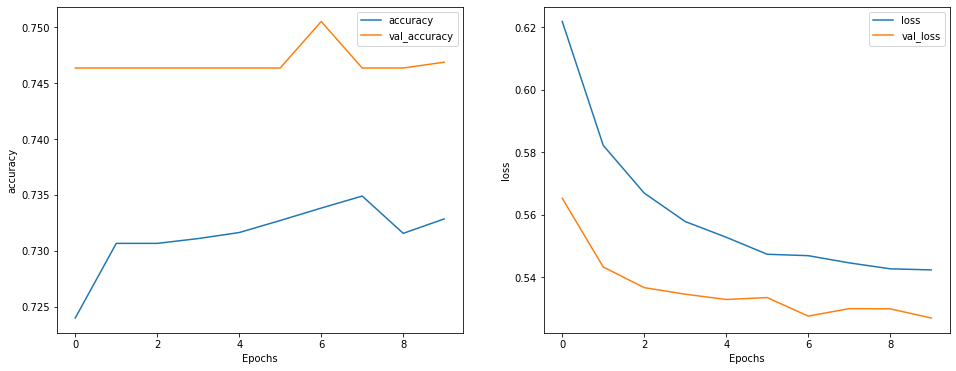

In [141]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyTD, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyTD, 'loss')

## Change Adam to RMSprop 

### relu

In [299]:
modelRDMS = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [300]:
modelRDMS.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-2),
              metrics=['accuracy'])

In [301]:
historyRDMS = modelRDMS.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 48s 44ms/step - loss: 0.7191 - accuracy: 0.7262 - val_loss: 0.5521 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5778 - accuracy: 0.7310 - val_loss: 0.5506 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 13s 31ms/step - loss: 0.5691 - accuracy: 0.7331 - val_loss: 0.5549 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 13s 31ms/step - loss: 0.5750 - accuracy: 0.7263 - val_loss: 0.5680 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5699 - accuracy: 0.7288 - val_loss: 0.5660 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5709 - accuracy: 0.7283 - val_loss: 0.5814 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 13s 31ms/step - loss: 0.5656 - accuracy: 0.7333 - val_loss: 0.5741 - val_accuracy:

In [302]:
test_loss, test_acc = modelRDMS.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 7ms/step - loss: 0.5842 - accuracy: 0.7336
Test Loss: 0.5841915607452393
Test Accuracy: 0.733623743057251


In [303]:
# np.around(model.predict(test_dataset_first.text),decimals=0).argmax(axis=1)

In [304]:
# np.array(test_dataset_first.label)

In [305]:
from sklearn.metrics import classification_report
predict=np.around(modelRDMS.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [306]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelRDMS.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


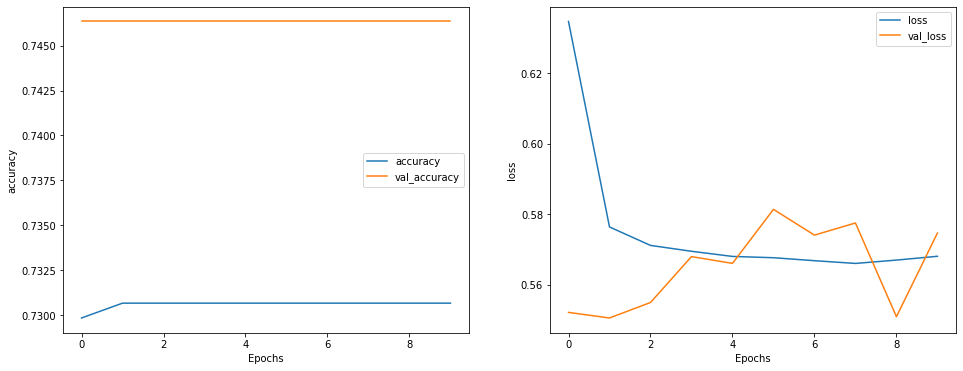

In [307]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyRDMS, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyRDMS, 'loss')

### sigmoid

In [308]:
modelSDMS = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [309]:
modelSDMS.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-2),
              metrics=['accuracy'])

In [310]:
historySDMS = modelSDMS.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 40s 42ms/step - loss: 0.7292 - accuracy: 0.6754 - val_loss: 0.5528 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5663 - accuracy: 0.7349 - val_loss: 0.5417 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5657 - accuracy: 0.7314 - val_loss: 0.5410 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5640 - accuracy: 0.7286 - val_loss: 0.5392 - val_accuracy: 0.7474
Epoch 5/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5619 - accuracy: 0.7306 - val_loss: 0.5480 - val_accuracy: 0.7469
Epoch 6/10
436/436 [==============================] - 13s 29ms/step - loss: 0.5588 - accuracy: 0.7358 - val_loss: 0.5595 - val_accuracy: 0.7510
Epoch 7/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5571 - accuracy: 0.7328 - val_loss: 0.5635 - val_accuracy:

In [311]:
test_loss, test_acc = modelSDMS.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 7ms/step - loss: 0.5724 - accuracy: 0.7353
Test Loss: 0.5724097490310669
Test Accuracy: 0.7352990508079529


In [312]:
from sklearn.metrics import classification_report
predict=np.around(modelSDMS.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7371    0.9935    0.8463      8758
           2     0.5746    0.0242    0.0465      3180

    accuracy                         0.7353     11938
   macro avg     0.6559    0.5089    0.4464     11938
weighted avg     0.6938    0.7353    0.6333     11938



In [313]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelSDMS.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


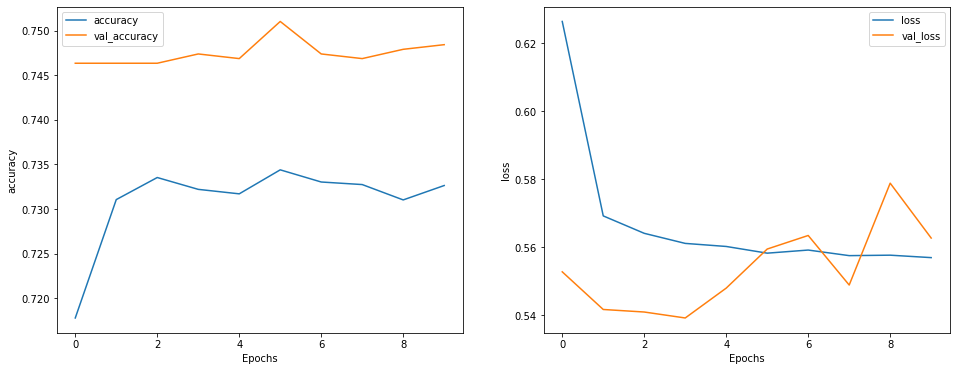

In [315]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historySDMS, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historySDMS, 'loss')

### tanh

In [124]:
modelTDMS = tf.keras.Sequential([
    encoder,
   tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [125]:
modelTDMS.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-2),
              metrics=['accuracy'])

In [126]:
historyTDMS = modelTDMS.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 32s 35ms/step - loss: 0.6664 - accuracy: 0.7042 - val_loss: 0.5426 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5657 - accuracy: 0.7292 - val_loss: 0.5356 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 10s 24ms/step - loss: 0.5585 - accuracy: 0.7307 - val_loss: 0.5377 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 10s 24ms/step - loss: 0.5576 - accuracy: 0.7285 - val_loss: 0.5591 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 10s 24ms/step - loss: 0.5483 - accuracy: 0.7327 - val_loss: 0.5630 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 10s 24ms/step - loss: 0.5538 - accuracy: 0.7316 - val_loss: 0.5826 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 10s 24ms/step - loss: 0.5529 - accuracy: 0.7325 - val_loss: 0.5572 - val_accuracy:

In [127]:
test_loss, test_acc = modelTDMS.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 5ms/step - loss: 0.5939 - accuracy: 0.7336
Test Loss: 0.5938819646835327
Test Accuracy: 0.733623743057251


In [128]:
from sklearn.metrics import classification_report
predict=np.around(modelTDMS.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [132]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelTDMS.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyTDMS, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyTDMS, 'loss')

## Adam without dropout before dense

### relu

In [111]:
modelRD = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [112]:
modelRD.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [113]:
historyRD = modelRD.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 32s 34ms/step - loss: 0.6386 - accuracy: 0.7271 - val_loss: 0.5311 - val_accuracy: 0.7510
Epoch 2/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5444 - accuracy: 0.7369 - val_loss: 0.5254 - val_accuracy: 0.7453
Epoch 3/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5388 - accuracy: 0.7396 - val_loss: 0.5252 - val_accuracy: 0.7479
Epoch 4/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5323 - accuracy: 0.7437 - val_loss: 0.5225 - val_accuracy: 0.7490
Epoch 5/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5307 - accuracy: 0.7394 - val_loss: 0.5219 - val_accuracy: 0.7500
Epoch 6/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5269 - accuracy: 0.7435 - val_loss: 0.5280 - val_accuracy: 0.7521
Epoch 7/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5249 - accuracy: 0.7429 - val_loss: 0.5243 - val_accuracy:

In [114]:
test_loss, test_acc = modelRD.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 5ms/step - loss: 0.5430 - accuracy: 0.7386
Test Loss: 0.5429824590682983
Test Accuracy: 0.7385659217834473


In [ ]:
# np.around(model.predict(test_dataset_first.text),decimals=0).argmax(axis=1)

In [ ]:
# np.array(test_dataset_first.label)

In [116]:
from sklearn.metrics import classification_report
predict=np.around(modelRD.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7518    0.9609    0.8436      8758
           2     0.5397    0.1261    0.2044      3180

    accuracy                         0.7386     11938
   macro avg     0.6457    0.5435    0.5240     11938
weighted avg     0.6953    0.7386    0.6733     11938



In [131]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelRDMS.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


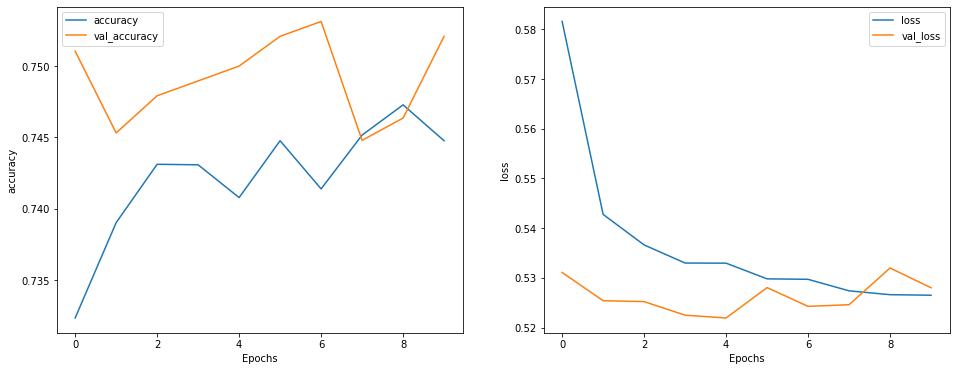

In [130]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyRD, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyRD, 'loss')

### sigmoid

In [117]:
modelSD = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [118]:
modelSD.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [119]:
historySD = modelSD.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 31s 34ms/step - loss: 0.7272 - accuracy: 0.6601 - val_loss: 0.5720 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 10s 24ms/step - loss: 0.5712 - accuracy: 0.7342 - val_loss: 0.5379 - val_accuracy: 0.7505
Epoch 3/10
436/436 [==============================] - 10s 24ms/step - loss: 0.5463 - accuracy: 0.7387 - val_loss: 0.5282 - val_accuracy: 0.7516
Epoch 4/10
436/436 [==============================] - 10s 24ms/step - loss: 0.5382 - accuracy: 0.7416 - val_loss: 0.5247 - val_accuracy: 0.7547
Epoch 5/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5350 - accuracy: 0.7434 - val_loss: 0.5256 - val_accuracy: 0.7557
Epoch 6/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5281 - accuracy: 0.7485 - val_loss: 0.5269 - val_accuracy: 0.7557
Epoch 7/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5263 - accuracy: 0.7484 - val_loss: 0.5240 - val_accuracy:

In [120]:
test_loss, test_acc = modelSD.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.5413 - accuracy: 0.7377
Test Loss: 0.5413213968276978
Test Accuracy: 0.7377282381057739


In [121]:
from sklearn.metrics import classification_report
predict=np.around(modelSD.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7538    0.9541    0.8422      8758
           2     0.5287    0.1418    0.2237      3180

    accuracy                         0.7377     11938
   macro avg     0.6413    0.5480    0.5329     11938
weighted avg     0.6939    0.7377    0.6774     11938



In [134]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelSD.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


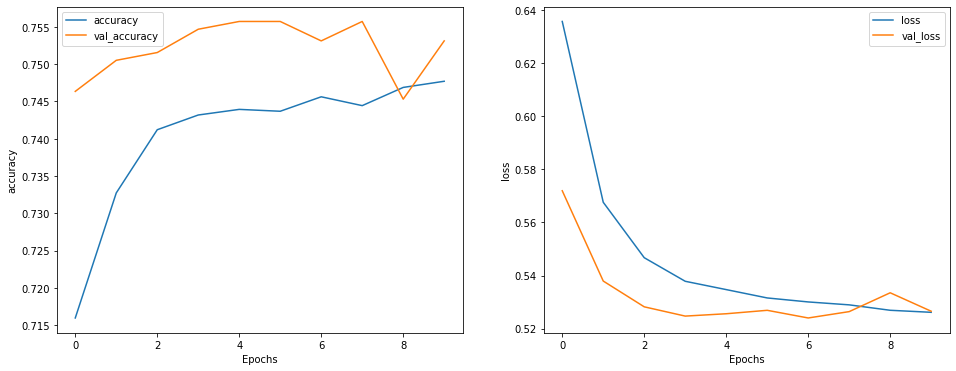

In [135]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historySD, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historySD, 'loss')

### tanh

In [136]:
modelTD = tf.keras.Sequential([
    encoder,
   tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [137]:
modelTD.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [138]:
historyTD = modelTD.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 31s 34ms/step - loss: 0.6319 - accuracy: 0.7260 - val_loss: 0.5334 - val_accuracy: 0.7469
Epoch 2/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5403 - accuracy: 0.7418 - val_loss: 0.5262 - val_accuracy: 0.7479
Epoch 3/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5385 - accuracy: 0.7408 - val_loss: 0.5242 - val_accuracy: 0.7495
Epoch 4/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5325 - accuracy: 0.7424 - val_loss: 0.5309 - val_accuracy: 0.7490
Epoch 5/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5327 - accuracy: 0.7418 - val_loss: 0.5282 - val_accuracy: 0.7526
Epoch 6/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5288 - accuracy: 0.7447 - val_loss: 0.5223 - val_accuracy: 0.7531
Epoch 7/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5303 - accuracy: 0.7430 - val_loss: 0.5254 - val_accuracy:

In [139]:
test_loss, test_acc = modelTD.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 5ms/step - loss: 0.5415 - accuracy: 0.7372
Test Loss: 0.5414662957191467
Test Accuracy: 0.7372256517410278


In [140]:
from sklearn.metrics import classification_report
predict=np.around(modelTD.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7472    0.9700    0.8441      8758
           2     0.5378    0.0962    0.1632      3180

    accuracy                         0.7372     11938
   macro avg     0.6425    0.5331    0.5037     11938
weighted avg     0.6914    0.7372    0.6628     11938



In [141]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelTD.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


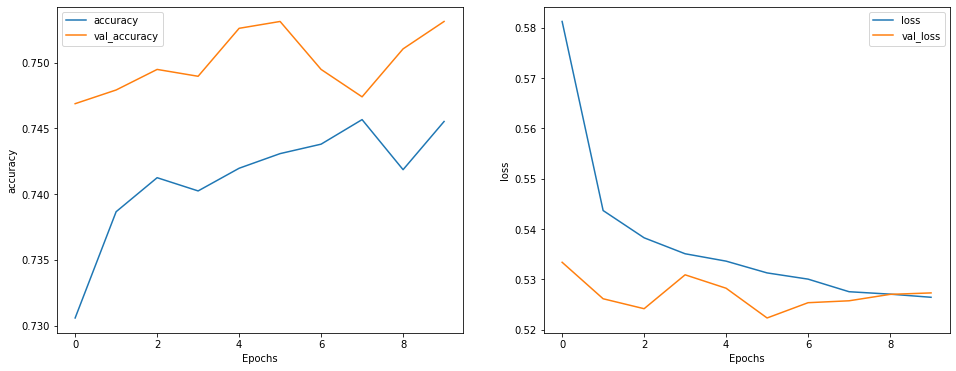

In [142]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyTD, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyTD, 'loss')

## Change Adam to RMSprop without dropout layer before dense

### relu

In [143]:
modelRDMS = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [144]:
modelRDMS.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-2),
              metrics=['accuracy'])

In [145]:
historyRDMS = modelRDMS.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 33s 34ms/step - loss: 0.6118 - accuracy: 0.7200 - val_loss: 0.5453 - val_accuracy: 0.7479
Epoch 2/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5498 - accuracy: 0.7363 - val_loss: 0.5729 - val_accuracy: 0.7453
Epoch 3/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5452 - accuracy: 0.7362 - val_loss: 0.5266 - val_accuracy: 0.7469
Epoch 4/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5382 - accuracy: 0.7368 - val_loss: 0.5338 - val_accuracy: 0.7490
Epoch 5/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5384 - accuracy: 0.7378 - val_loss: 0.5259 - val_accuracy: 0.7531
Epoch 6/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5381 - accuracy: 0.7369 - val_loss: 0.6414 - val_accuracy: 0.7266
Epoch 7/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5372 - accuracy: 0.7377 - val_loss: 0.7785 - val_accuracy:

In [146]:
test_loss, test_acc = modelRDMS.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.7094 - accuracy: 0.4179
Test Loss: 0.7093780636787415
Test Accuracy: 0.4179092049598694


In [251]:
# np.around(model.predict(test_dataset_first.text),decimals=0).argmax(axis=1)

In [252]:
# np.array(test_dataset_first.label)

In [147]:
from sklearn.metrics import classification_report
predict=np.around(modelRDMS.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7854    0.2842    0.4174      8758
           2     0.2851    0.7862    0.4184      3180

    accuracy                         0.4179     11938
   macro avg     0.5353    0.5352    0.4179     11938
weighted avg     0.6521    0.4179    0.4177     11938



In [148]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelRDMS.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[2]


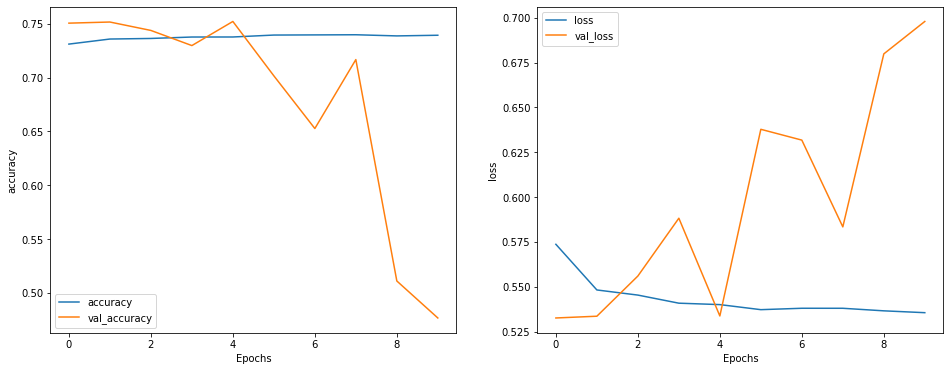

In [285]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyRDMS, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyRDMS, 'loss')

### sigmoid

In [286]:
modelSDMS = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [287]:
modelSDMS.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-2),
              metrics=['accuracy'])

In [288]:
historySDMS = modelSDMS.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 42s 44ms/step - loss: 0.6664 - accuracy: 0.6937 - val_loss: 0.5311 - val_accuracy: 0.7531
Epoch 2/10
436/436 [==============================] - 13s 29ms/step - loss: 0.5471 - accuracy: 0.7383 - val_loss: 0.5446 - val_accuracy: 0.7328
Epoch 3/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5451 - accuracy: 0.7350 - val_loss: 0.5435 - val_accuracy: 0.7500
Epoch 4/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5441 - accuracy: 0.7341 - val_loss: 0.6621 - val_accuracy: 0.6156
Epoch 5/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5335 - accuracy: 0.7422 - val_loss: 0.5969 - val_accuracy: 0.6859
Epoch 6/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5358 - accuracy: 0.7417 - val_loss: 0.7270 - val_accuracy: 0.3453
Epoch 7/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5376 - accuracy: 0.7338 - val_loss: 0.6924 - val_accuracy:

In [289]:
test_loss, test_acc = modelSDMS.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 7ms/step - loss: 0.7075 - accuracy: 0.4682
Test Loss: 0.7074962854385376
Test Accuracy: 0.46816888451576233


In [290]:
from sklearn.metrics import classification_report
predict=np.around(modelSDMS.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.8749    0.3210    0.4696      8758
           2     0.3184    0.8736    0.4667      3180

    accuracy                         0.4682     11938
   macro avg     0.5966    0.5973    0.4682     11938
weighted avg     0.7266    0.4682    0.4689     11938



In [291]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelSDMS.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[2]


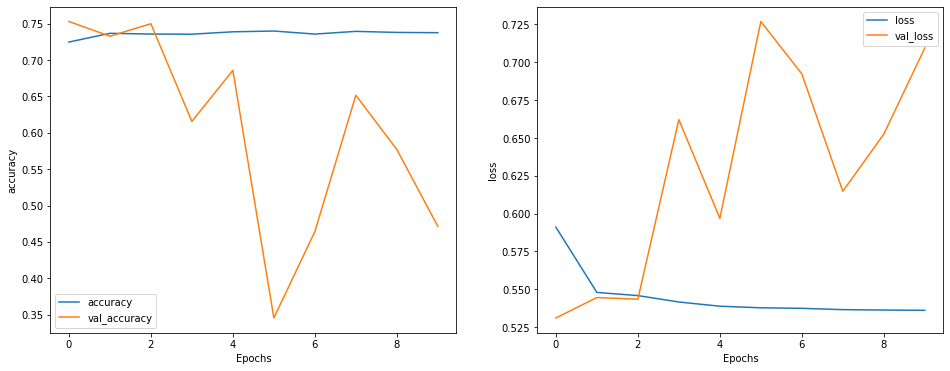

In [292]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historySDMS, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historySDMS, 'loss')

### tanh

In [149]:
modelTDMS = tf.keras.Sequential([
    encoder,
   tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [150]:
modelTDMS.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-2),
              metrics=['accuracy'])

In [151]:
historyTDMS = modelTDMS.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 33s 34ms/step - loss: 0.6058 - accuracy: 0.7231 - val_loss: 0.5347 - val_accuracy: 0.7484
Epoch 2/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5521 - accuracy: 0.7325 - val_loss: 0.5355 - val_accuracy: 0.7484
Epoch 3/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5431 - accuracy: 0.7415 - val_loss: 0.5223 - val_accuracy: 0.7526
Epoch 4/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5408 - accuracy: 0.7408 - val_loss: 0.6391 - val_accuracy: 0.6698
Epoch 5/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5393 - accuracy: 0.7386 - val_loss: 0.6209 - val_accuracy: 0.6984
Epoch 6/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5386 - accuracy: 0.7343 - val_loss: 0.6799 - val_accuracy: 0.6052
Epoch 7/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5337 - accuracy: 0.7425 - val_loss: 0.7998 - val_accuracy:

In [154]:
test_loss, test_acc = modelTDMS.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.6506 - accuracy: 0.6136
Test Loss: 0.6505816578865051
Test Accuracy: 0.6135868430137634


In [155]:
from sklearn.metrics import classification_report
predict=np.around(modelTDMS.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.8022    0.6282    0.7046      8758
           2     0.3589    0.5733    0.4415      3180

    accuracy                         0.6136     11938
   macro avg     0.5805    0.6007    0.5730     11938
weighted avg     0.6841    0.6136    0.6345     11938



In [156]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelTDMS.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


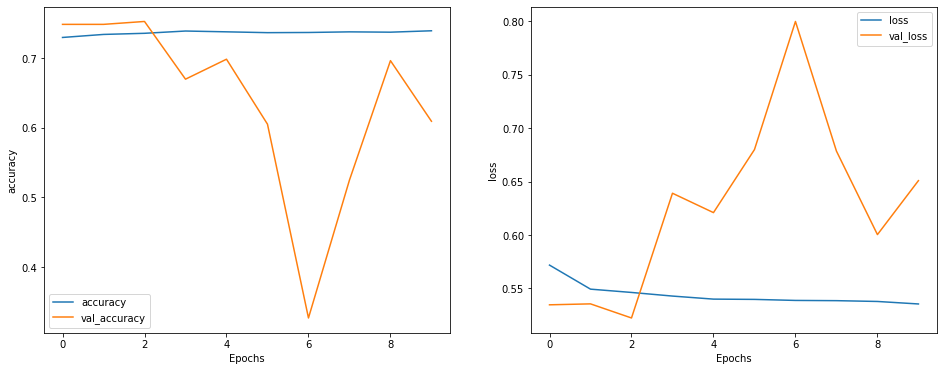

In [157]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyTDMS, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyTDMS, 'loss')

## Using GRU and Adam

### relu

In [323]:
modelRDGR = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(3)),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [324]:
modelRDGR.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [325]:
historyRDGR = modelRDGR.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 24s 35ms/step - loss: 0.7032 - accuracy: 0.7284 - val_loss: 0.5508 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 14s 32ms/step - loss: 0.5820 - accuracy: 0.7303 - val_loss: 0.5405 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 14s 33ms/step - loss: 0.5663 - accuracy: 0.7336 - val_loss: 0.5473 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 14s 33ms/step - loss: 0.5666 - accuracy: 0.7304 - val_loss: 0.5366 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 14s 33ms/step - loss: 0.5663 - accuracy: 0.7279 - val_loss: 0.5410 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 14s 32ms/step - loss: 0.5549 - accuracy: 0.7354 - val_loss: 0.5387 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 14s 32ms/step - loss: 0.5577 - accuracy: 0.7326 - val_loss: 0.5498 - val_accuracy:

In [326]:
test_loss, test_acc = modelRDGR.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 2s 8ms/step - loss: 0.5512 - accuracy: 0.7336
Test Loss: 0.5511558651924133
Test Accuracy: 0.733623743057251


In [327]:
# np.around(model.predict(test_dataset_first.text),decimals=0).argmax(axis=1)

In [328]:
# np.array(test_dataset_first.label)

In [329]:
from sklearn.metrics import classification_report
predict=np.around(modelRDGR.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [330]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelRDGR.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


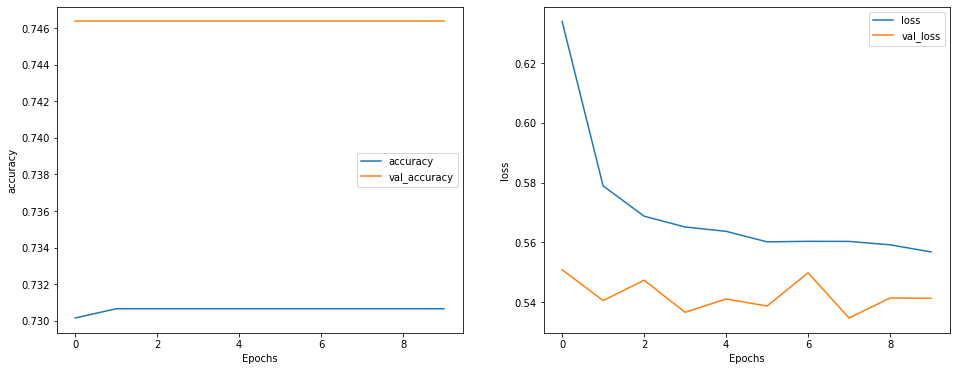

In [331]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyRDGR, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyRDGR, 'loss')

### sigmoid

In [332]:
modelSDMS = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(3)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [333]:
modelSDMS.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [334]:
historySDMS = modelSDMS.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 24s 35ms/step - loss: 0.7498 - accuracy: 0.6958 - val_loss: 0.5609 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 14s 32ms/step - loss: 0.5799 - accuracy: 0.7305 - val_loss: 0.5469 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 14s 33ms/step - loss: 0.5684 - accuracy: 0.7328 - val_loss: 0.5368 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 14s 32ms/step - loss: 0.5631 - accuracy: 0.7336 - val_loss: 0.5317 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 14s 32ms/step - loss: 0.5585 - accuracy: 0.7358 - val_loss: 0.5362 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 14s 32ms/step - loss: 0.5529 - accuracy: 0.7405 - val_loss: 0.5299 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 14s 32ms/step - loss: 0.5504 - accuracy: 0.7402 - val_loss: 0.5416 - val_accuracy:

In [335]:
test_loss, test_acc = modelSDMS.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 8ms/step - loss: 0.5490 - accuracy: 0.7336
Test Loss: 0.548977792263031
Test Accuracy: 0.733623743057251


In [336]:
from sklearn.metrics import classification_report
predict=np.around(modelSDMS.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [337]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelSDMS.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


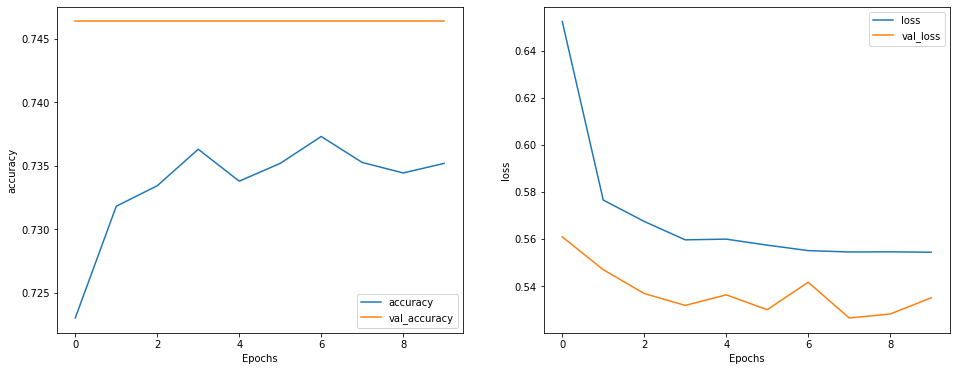

In [338]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historySDMS, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historySDMS, 'loss')

### tanh

In [339]:
modelTDMS = tf.keras.Sequential([
    encoder,
   tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [340]:
modelTDMS.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [341]:
historyTDMS = modelTDMS.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 40s 44ms/step - loss: 0.6855 - accuracy: 0.6832 - val_loss: 0.5661 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5921 - accuracy: 0.7277 - val_loss: 0.5594 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 13s 31ms/step - loss: 0.5762 - accuracy: 0.7300 - val_loss: 0.5406 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5657 - accuracy: 0.7284 - val_loss: 0.5395 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5547 - accuracy: 0.7330 - val_loss: 0.5296 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5498 - accuracy: 0.7336 - val_loss: 0.5286 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5430 - accuracy: 0.7354 - val_loss: 0.5270 - val_accuracy:

In [342]:
test_loss, test_acc = modelTDMS.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 7ms/step - loss: 0.5455 - accuracy: 0.7336
Test Loss: 0.5455469489097595
Test Accuracy: 0.733623743057251


In [343]:
from sklearn.metrics import classification_report
predict=np.around(modelTDMS.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7337    0.9999    0.8463      8758
           2     0.5000    0.0003    0.0006      3180

    accuracy                         0.7336     11938
   macro avg     0.6168    0.5001    0.4235     11938
weighted avg     0.6714    0.7336    0.6211     11938



In [344]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelTDMS.predict(np.array([sample_text]))
print(predictions)

[[7.1089536e-01 2.5282483e-04 2.8885186e-01]]


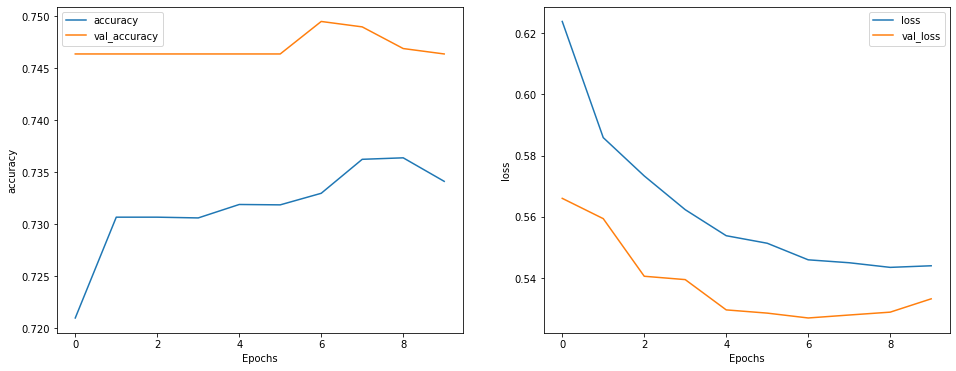

In [346]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyTDMS, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyTDMS, 'loss')

## Using RMSprop and Gru

### relu

In [158]:
modelRDGRRM = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(3)),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [159]:
modelRDGRRM.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop (1e-2),
              metrics=['accuracy'])

In [160]:
historyRDGRRM = modelRDGRRM.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 18s 28ms/step - loss: 0.6903 - accuracy: 0.7294 - val_loss: 0.5497 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5661 - accuracy: 0.7320 - val_loss: 0.5402 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5656 - accuracy: 0.7333 - val_loss: 0.5429 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5631 - accuracy: 0.7314 - val_loss: 0.5680 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5592 - accuracy: 0.7323 - val_loss: 0.5649 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5607 - accuracy: 0.7325 - val_loss: 0.5465 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5595 - accuracy: 0.7343 - val_loss: 0.5761 - val_accuracy:

In [161]:
test_loss, test_acc = modelRDGRRM.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.5732 - accuracy: 0.7336
Test Loss: 0.5732457637786865
Test Accuracy: 0.733623743057251


In [ ]:
# np.around(model.predict(test_dataset_first.text),decimals=0).argmax(axis=1)

In [ ]:
# np.array(test_dataset_first.label)

In [162]:
from sklearn.metrics import classification_report
predict=np.around(modelRDGRRM.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [163]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelRDGRRM.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


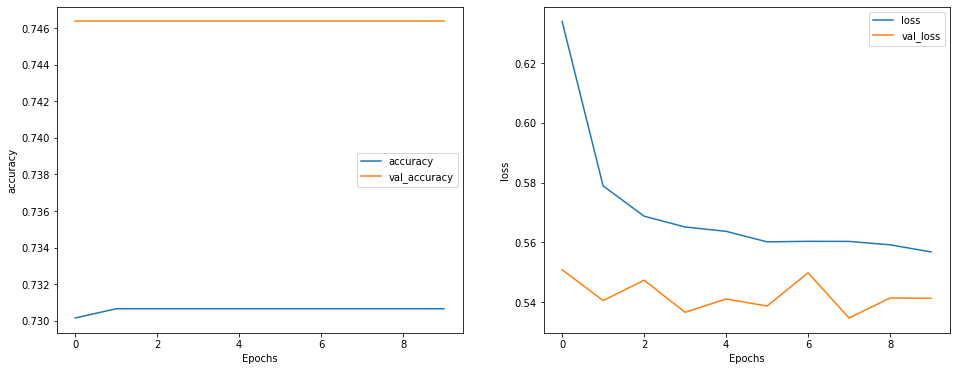

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyRDGRRM, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyRDGRRM, 'loss')

### sigmoid

In [164]:
modelSDMSRM = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(3)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [165]:
modelSDMSRM.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop (1e-2),
              metrics=['accuracy'])

In [166]:
historySDMSRM = modelSDMSRM.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 18s 28ms/step - loss: 0.6808 - accuracy: 0.7118 - val_loss: 0.5469 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5719 - accuracy: 0.7279 - val_loss: 0.5374 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5659 - accuracy: 0.7298 - val_loss: 0.5405 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5600 - accuracy: 0.7330 - val_loss: 0.5640 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5595 - accuracy: 0.7347 - val_loss: 0.5568 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5610 - accuracy: 0.7325 - val_loss: 0.5788 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5633 - accuracy: 0.7281 - val_loss: 0.5591 - val_accuracy:

In [167]:
test_loss, test_acc = modelSDMSRM.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.5925 - accuracy: 0.7336
Test Loss: 0.5924953818321228
Test Accuracy: 0.733623743057251


In [169]:
from sklearn.metrics import classification_report
predict=np.around(modelSDMSRM.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [175]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelSDMSRM.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


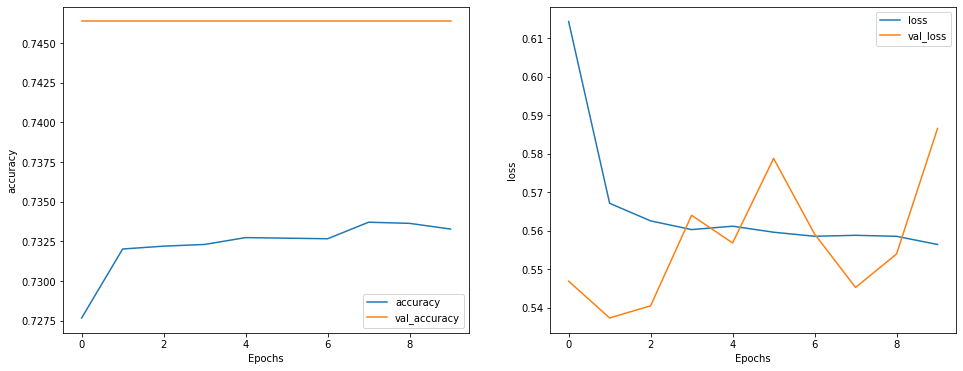

In [176]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historySDMSRM, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historySDMSRM, 'loss')

### tanh

In [177]:
modelTDMSRM = tf.keras.Sequential([
    encoder,
   tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(3)),
    tf.keras.layers.Dense(3, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [178]:
modelTDMSRM.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-2),
              metrics=['accuracy'])

In [179]:
historyTDMSRM = modelTDMSRM.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 18s 27ms/step - loss: 0.6541 - accuracy: 0.7303 - val_loss: 0.5457 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5674 - accuracy: 0.7279 - val_loss: 0.5411 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5607 - accuracy: 0.7286 - val_loss: 0.5322 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5545 - accuracy: 0.7321 - val_loss: 0.5284 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5505 - accuracy: 0.7313 - val_loss: 0.5740 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5517 - accuracy: 0.7327 - val_loss: 0.5877 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5543 - accuracy: 0.7290 - val_loss: 0.5805 - val_accuracy:

In [180]:
test_loss, test_acc = modelTDMSRM.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.5688 - accuracy: 0.7341
Test Loss: 0.568793773651123
Test Accuracy: 0.7341263294219971


In [181]:
from sklearn.metrics import classification_report
predict=np.around(modelTDMSRM.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7346    0.9982    0.8464      8758
           2     0.5789    0.0069    0.0137      3180

    accuracy                         0.7341     11938
   macro avg     0.6568    0.5025    0.4300     11938
weighted avg     0.6932    0.7341    0.6245     11938



In [182]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelTDMSRM.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


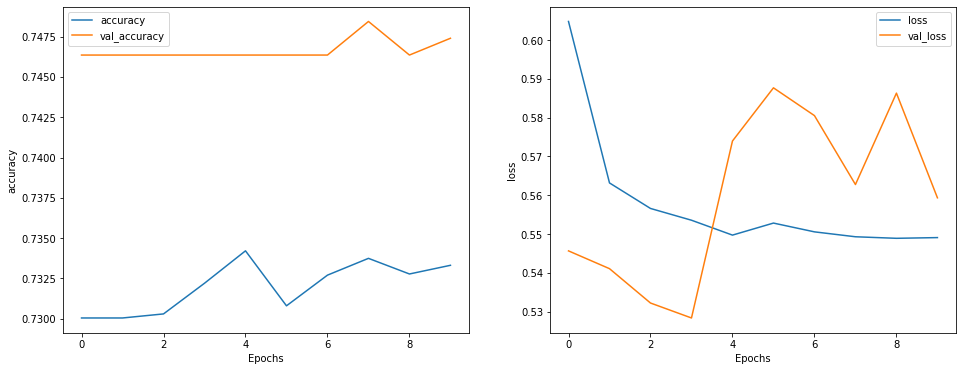

In [183]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyTDMSRM, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyTDMSRM, 'loss')

## Using GRU and Adam without dropoud layer before dense

### relu

In [ ]:
modelRDGR = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(3)),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
modelRDGR.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [ ]:
historyRDGR = modelRDGR.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 22s 32ms/step - loss: 0.6252 - accuracy: 0.7320 - val_loss: 0.5299 - val_accuracy: 0.7505
Epoch 2/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5412 - accuracy: 0.7352 - val_loss: 0.5346 - val_accuracy: 0.7516
Epoch 3/10
436/436 [==============================] - 13s 29ms/step - loss: 0.5394 - accuracy: 0.7355 - val_loss: 0.5301 - val_accuracy: 0.7526
Epoch 4/10
436/436 [==============================] - 13s 29ms/step - loss: 0.5386 - accuracy: 0.7361 - val_loss: 0.5227 - val_accuracy: 0.7495
Epoch 5/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5335 - accuracy: 0.7384 - val_loss: 0.5238 - val_accuracy: 0.7536
Epoch 6/10
436/436 [==============================] - 13s 29ms/step - loss: 0.5279 - accuracy: 0.7427 - val_loss: 0.5376 - val_accuracy: 0.7427
Epoch 7/10
436/436 [==============================] - 13s 29ms/step - loss: 0.5245 - accuracy: 0.7457 - val_loss: 0.5275 - val_accuracy:

In [ ]:
test_loss, test_acc = modelRDGR.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 7ms/step - loss: 0.5393 - accuracy: 0.7382
Test Loss: 0.5392864346504211
Test Accuracy: 0.7382308840751648


In [ ]:
# np.around(model.predict(test_dataset_first.text),decimals=0).argmax(axis=1)

In [ ]:
# np.array(test_dataset_first.label)

In [ ]:
from sklearn.metrics import classification_report
predict=np.around(modelRDGR.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7519    0.9599    0.8433      8758
           2     0.5363    0.1277    0.2062      3180

    accuracy                         0.7382     11938
   macro avg     0.6441    0.5438    0.5248     11938
weighted avg     0.6945    0.7382    0.6736     11938



In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelRDGR.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


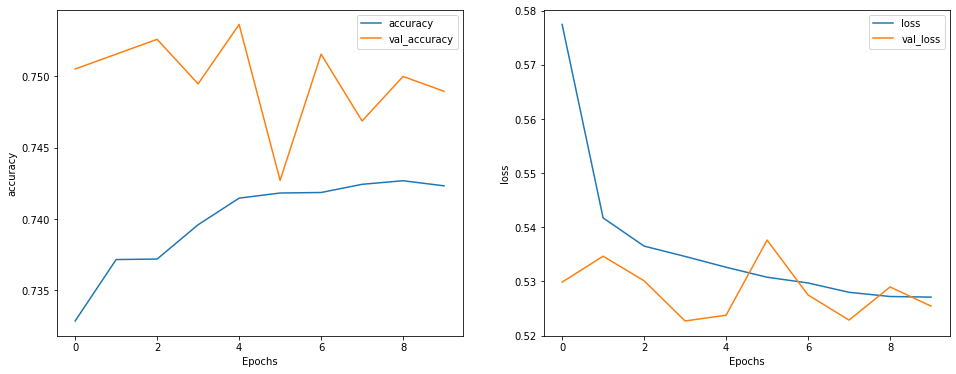

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyRDGR, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyRDGR, 'loss')

### sigmoid

In [ ]:
modelSDMS = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(3)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
modelSDMS.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [ ]:
historySDMS = modelSDMS.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 21s 32ms/step - loss: 0.8430 - accuracy: 0.6308 - val_loss: 0.5511 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5602 - accuracy: 0.7299 - val_loss: 0.5341 - val_accuracy: 0.7516
Epoch 3/10
436/436 [==============================] - 13s 29ms/step - loss: 0.5451 - accuracy: 0.7394 - val_loss: 0.5291 - val_accuracy: 0.7458
Epoch 4/10
436/436 [==============================] - 13s 29ms/step - loss: 0.5367 - accuracy: 0.7366 - val_loss: 0.5263 - val_accuracy: 0.7474
Epoch 5/10
436/436 [==============================] - 13s 29ms/step - loss: 0.5384 - accuracy: 0.7374 - val_loss: 0.5266 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 12s 29ms/step - loss: 0.5394 - accuracy: 0.7392 - val_loss: 0.5252 - val_accuracy: 0.7490
Epoch 7/10
436/436 [==============================] - 13s 29ms/step - loss: 0.5323 - accuracy: 0.7412 - val_loss: 0.5247 - val_accuracy:

In [ ]:
test_loss, test_acc = modelSDMS.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 7ms/step - loss: 0.5410 - accuracy: 0.7393
Test Loss: 0.5410363078117371
Test Accuracy: 0.7393198013305664


In [ ]:
from sklearn.metrics import classification_report
predict=np.around(modelSDMS.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7528    0.9599    0.8438      8758
           2     0.5442    0.1318    0.2122      3180

    accuracy                         0.7393     11938
   macro avg     0.6485    0.5458    0.5280     11938
weighted avg     0.6972    0.7393    0.6756     11938



In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelSDMS.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


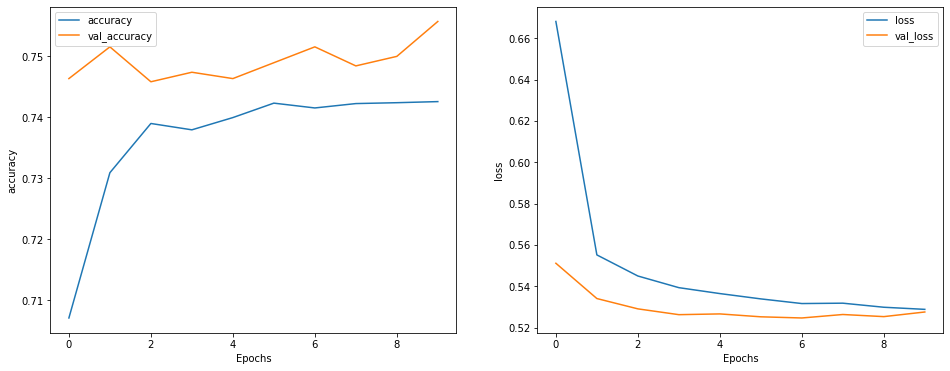

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historySDMS, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historySDMS, 'loss')

### tanh

In [191]:
modelTDMS = tf.keras.Sequential([
    encoder,
   tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(3)),
    tf.keras.layers.Dense(3, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [192]:
modelTDMS.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [193]:
historyTDMS = modelTDMS.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 18s 28ms/step - loss: 0.6176 - accuracy: 0.7247 - val_loss: 0.5335 - val_accuracy: 0.7474
Epoch 2/10
436/436 [==============================] - 12s 27ms/step - loss: 0.5427 - accuracy: 0.7387 - val_loss: 0.5264 - val_accuracy: 0.7453
Epoch 3/10
436/436 [==============================] - 12s 27ms/step - loss: 0.5374 - accuracy: 0.7377 - val_loss: 0.5248 - val_accuracy: 0.7500
Epoch 4/10
436/436 [==============================] - 12s 27ms/step - loss: 0.5332 - accuracy: 0.7399 - val_loss: 0.5251 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 12s 28ms/step - loss: 0.5280 - accuracy: 0.7432 - val_loss: 0.5237 - val_accuracy: 0.7469
Epoch 6/10
436/436 [==============================] - 12s 28ms/step - loss: 0.5322 - accuracy: 0.7394 - val_loss: 0.5269 - val_accuracy: 0.7500
Epoch 7/10
436/436 [==============================] - 12s 28ms/step - loss: 0.5279 - accuracy: 0.7434 - val_loss: 0.5321 - val_accuracy:

In [194]:
test_loss, test_acc = modelTDMS.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.5453 - accuracy: 0.7361
Test Loss: 0.5452558994293213
Test Accuracy: 0.7361367344856262


In [195]:
from sklearn.metrics import classification_report
predict=np.around(modelTDMS.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7604    0.9350    0.8387      8758
           2     0.5128    0.1884    0.2755      3180

    accuracy                         0.7361     11938
   macro avg     0.6366    0.5617    0.5571     11938
weighted avg     0.6944    0.7361    0.6887     11938



In [196]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelTDMS.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


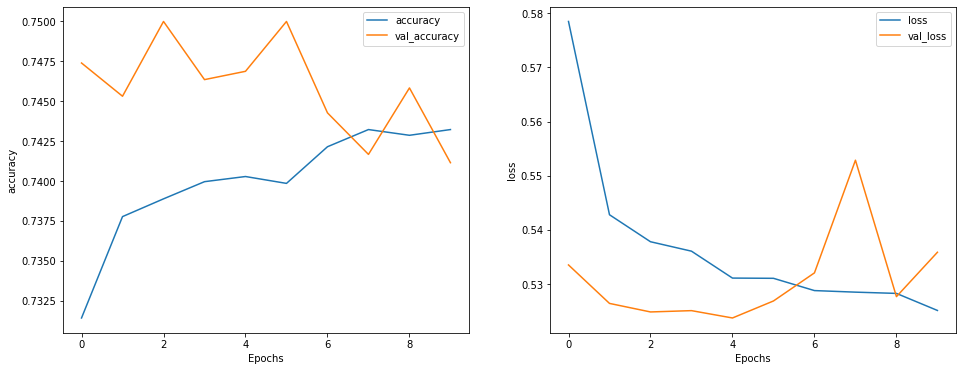

In [197]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyTDMS, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyTDMS, 'loss')

## Gru RPSprop without dropout layer before dense

### relu

In [198]:
modelRDGRRM = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(3)),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [199]:
modelRDGRRM.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-2),
              metrics=['accuracy'])

In [201]:
historyRDGRRM = modelRDGRRM.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5473 - accuracy: 0.7344 - val_loss: 0.5301 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5417 - accuracy: 0.7360 - val_loss: 0.5379 - val_accuracy: 0.7547
Epoch 3/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5407 - accuracy: 0.7362 - val_loss: 0.5642 - val_accuracy: 0.7531
Epoch 4/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5387 - accuracy: 0.7384 - val_loss: 0.6003 - val_accuracy: 0.7401
Epoch 5/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5378 - accuracy: 0.7387 - val_loss: 0.6844 - val_accuracy: 0.5500
Epoch 6/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5367 - accuracy: 0.7391 - val_loss: 0.6068 - val_accuracy: 0.7344
Epoch 7/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5359 - accuracy: 0.7382 - val_loss: 0.6458 - val_accuracy:

In [202]:
test_loss, test_acc = modelRDGRRM.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.7020 - accuracy: 0.5280
Test Loss: 0.7020267844200134
Test Accuracy: 0.5279778838157654


In [ ]:
# np.around(model.predict(test_dataset_first.text),decimals=0).argmax(axis=1)

In [ ]:
# np.array(test_dataset_first.label)

In [203]:
from sklearn.metrics import classification_report
predict=np.around(modelRDGRRM.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.8433    0.4380    0.5765      8758
           2     0.3339    0.7758    0.4668      3180

    accuracy                         0.5280     11938
   macro avg     0.5886    0.6069    0.5217     11938
weighted avg     0.7076    0.5280    0.5473     11938



In [204]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelRDGRRM.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[2]


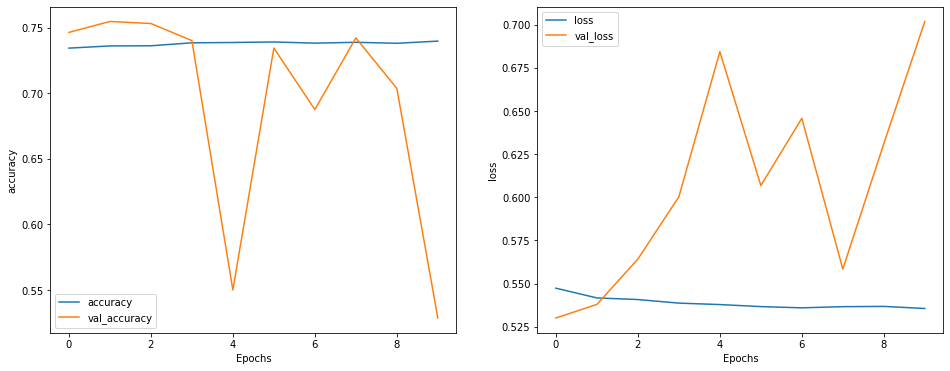

In [205]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyRDGRRM, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyRDGRRM, 'loss')

### sigmoid

In [206]:
modelSDMSRM = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(3)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [208]:
modelSDMSRM.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-2),
              metrics=['accuracy'])

In [209]:
historySDMSRM = modelSDMSRM.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 18s 27ms/step - loss: 0.6483 - accuracy: 0.7244 - val_loss: 0.5586 - val_accuracy: 0.7214
Epoch 2/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5483 - accuracy: 0.7374 - val_loss: 0.5296 - val_accuracy: 0.7505
Epoch 3/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5411 - accuracy: 0.7388 - val_loss: 0.5286 - val_accuracy: 0.7516
Epoch 4/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5433 - accuracy: 0.7344 - val_loss: 0.5832 - val_accuracy: 0.7411
Epoch 5/10
436/436 [==============================] - 12s 26ms/step - loss: 0.5395 - accuracy: 0.7362 - val_loss: 0.5818 - val_accuracy: 0.7417
Epoch 6/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5388 - accuracy: 0.7343 - val_loss: 0.6322 - val_accuracy: 0.7193
Epoch 7/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5387 - accuracy: 0.7386 - val_loss: 0.5844 - val_accuracy:

In [210]:
test_loss, test_acc = modelSDMSRM.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.6297 - accuracy: 0.6948
Test Loss: 0.6297391057014465
Test Accuracy: 0.694756269454956


In [211]:
from sklearn.metrics import classification_report
predict=np.around(modelSDMSRM.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7780    0.8171    0.7971      8758
           2     0.4153    0.3579    0.3845      3180

    accuracy                         0.6948     11938
   macro avg     0.5967    0.5875    0.5908     11938
weighted avg     0.6814    0.6948    0.6872     11938



In [212]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelSDMSRM.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


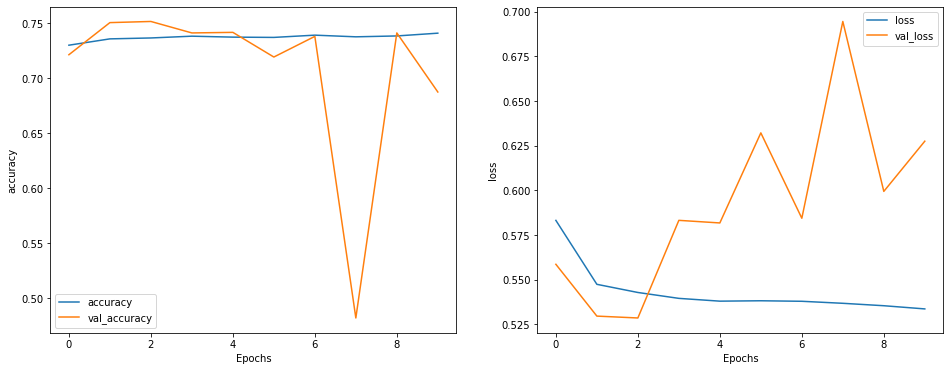

In [213]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historySDMSRM, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historySDMSRM, 'loss')

### tanh

In [214]:
modelTDMSRM = tf.keras.Sequential([
    encoder,
   tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(3)),
    tf.keras.layers.Dense(3, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [215]:
modelTDMS.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-2),
              metrics=['accuracy'])

In [216]:
historyTDMSRM = modelSDMSRM.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5352 - accuracy: 0.7381 - val_loss: 0.7291 - val_accuracy: 0.3552
Epoch 2/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5342 - accuracy: 0.7369 - val_loss: 0.5641 - val_accuracy: 0.7401
Epoch 3/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5332 - accuracy: 0.7424 - val_loss: 0.8075 - val_accuracy: 0.2599
Epoch 4/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5347 - accuracy: 0.7408 - val_loss: 0.6505 - val_accuracy: 0.6875
Epoch 5/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5324 - accuracy: 0.7415 - val_loss: 0.5759 - val_accuracy: 0.7333
Epoch 6/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5330 - accuracy: 0.7414 - val_loss: 0.5626 - val_accuracy: 0.7354
Epoch 7/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5336 - accuracy: 0.7397 - val_loss: 0.5387 - val_accuracy:

In [221]:
test_loss, test_acc = modelSDMSRM.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.5759 - accuracy: 0.7282
Test Loss: 0.5758779048919678
Test Accuracy: 0.7281789183616638


In [222]:
from sklearn.metrics import classification_report
predict=np.around(modelSDMSRM.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7657    0.9069    0.8304      8758
           2     0.4792    0.2358    0.3161      3180

    accuracy                         0.7282     11938
   macro avg     0.6225    0.5714    0.5733     11938
weighted avg     0.6894    0.7282    0.6934     11938



In [223]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelSDMSRM.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


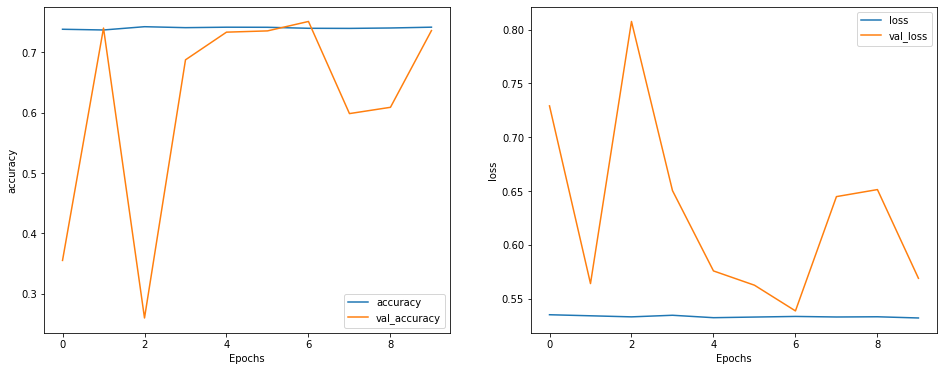

In [224]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyTDMSRM, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyTDMSRM, 'loss')

## Learning rate=0.1

### using LSTM and Adam

### relu

In [225]:
modelR1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [226]:
modelR1.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-1),
              metrics=['accuracy'])

In [227]:
historyR1 = modelR1.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 31s 34ms/step - loss: 0.6247 - accuracy: 0.7219 - val_loss: 0.5683 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5847 - accuracy: 0.7312 - val_loss: 0.5666 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5858 - accuracy: 0.7296 - val_loss: 0.5722 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5853 - accuracy: 0.7306 - val_loss: 0.5683 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5874 - accuracy: 0.7280 - val_loss: 0.5677 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5835 - accuracy: 0.7318 - val_loss: 0.5689 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5843 - accuracy: 0.7315 - val_loss: 0.5676 - val_accuracy:

In [228]:
test_loss, test_acc = modelR1.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.5801 - accuracy: 0.7336
Test Loss: 0.5800762176513672
Test Accuracy: 0.733623743057251


In [229]:
from sklearn.metrics import classification_report
predict=np.around(modelR1.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [230]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelR1.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


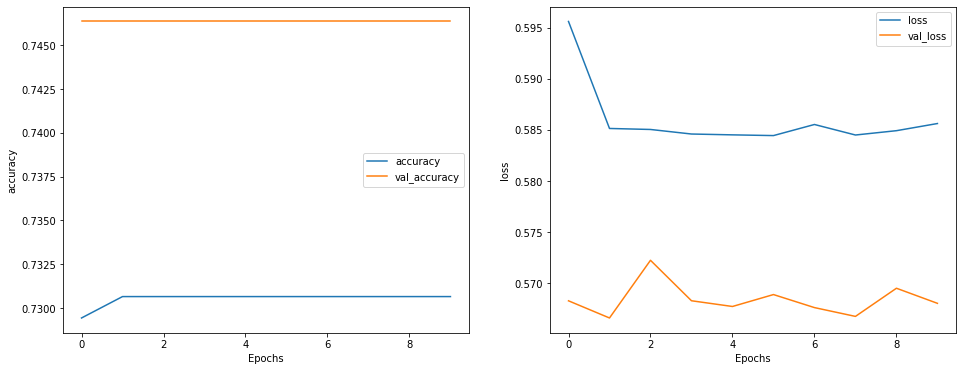

In [231]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyR1, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyR1, 'loss')

## sigmoid

In [430]:
modelS = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [431]:
modelS.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-1),
              metrics=['accuracy'])

In [432]:
historyS = modelS.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 50s 63ms/step - loss: 0.6305 - accuracy: 0.7187 - val_loss: 0.5623 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 14s 32ms/step - loss: 0.5844 - accuracy: 0.7259 - val_loss: 0.5694 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 14s 33ms/step - loss: 0.5815 - accuracy: 0.7295 - val_loss: 0.5593 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 14s 32ms/step - loss: 0.5824 - accuracy: 0.7289 - val_loss: 0.5621 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 14s 32ms/step - loss: 0.5805 - accuracy: 0.7290 - val_loss: 0.5606 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 14s 31ms/step - loss: 0.5811 - accuracy: 0.7292 - val_loss: 0.5713 - val_accuracy: 0.7469
Epoch 7/10
436/436 [==============================] - 15s 33ms/step - loss: 0.5804 - accuracy: 0.7282 - val_loss: 0.5682 - val_accuracy:

In [433]:
test_loss, test_acc = modelS.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 2s 8ms/step - loss: 0.5721 - accuracy: 0.7336
Test Loss: 0.5721195340156555
Test Accuracy: 0.733623743057251


In [434]:
from sklearn.metrics import classification_report
predict=np.around(modelS.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [435]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelS.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


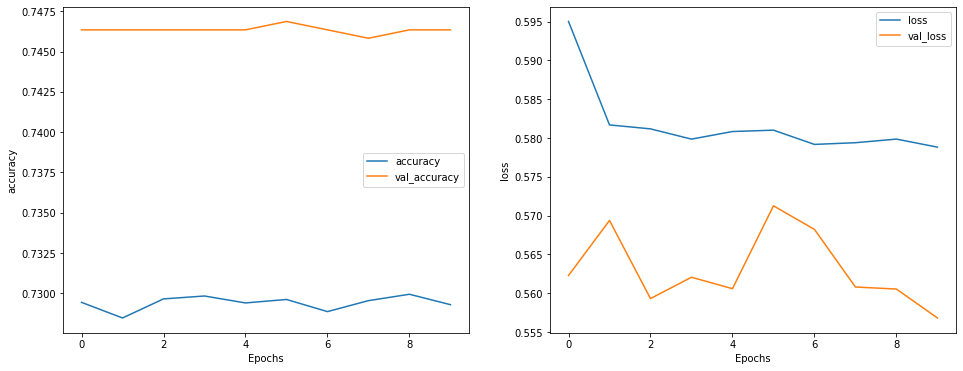

In [436]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyS, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyS, 'loss')

## tanh

In [437]:
modelT = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [438]:
modelT.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-1),
              metrics=['accuracy'])

In [439]:
historyT = modelT.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 41s 44ms/step - loss: 0.6165 - accuracy: 0.7241 - val_loss: 0.5677 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 13s 31ms/step - loss: 0.5866 - accuracy: 0.7294 - val_loss: 0.5666 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 13s 31ms/step - loss: 0.5858 - accuracy: 0.7314 - val_loss: 0.5664 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 14s 31ms/step - loss: 0.5865 - accuracy: 0.7310 - val_loss: 0.5712 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 14s 31ms/step - loss: 0.5847 - accuracy: 0.7302 - val_loss: 0.5675 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 14s 31ms/step - loss: 0.5871 - accuracy: 0.7287 - val_loss: 0.5666 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 13s 31ms/step - loss: 0.5873 - accuracy: 0.7308 - val_loss: 0.5676 - val_accuracy:

In [444]:
test_loss, test_acc = modelT.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 7ms/step - loss: 0.5796 - accuracy: 0.7336
Test Loss: 0.5796136856079102
Test Accuracy: 0.733623743057251


In [445]:
from sklearn.metrics import classification_report
predict=np.around(modelT.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [446]:

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelT.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


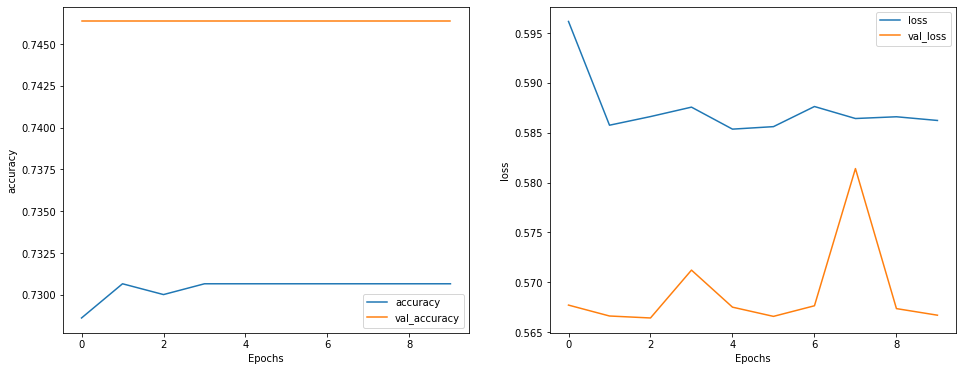

In [447]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyT, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyT, 'loss')

## LSTM and RMSprop

### relu

In [232]:
modelR1R = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [235]:
modelR1R.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-1),
              metrics=['accuracy'])

In [236]:
historyR1R = modelR1R.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 27s 34ms/step - loss: 0.6182 - accuracy: 0.7232 - val_loss: 0.5715 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 10s 24ms/step - loss: 0.5881 - accuracy: 0.7283 - val_loss: 0.5677 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5900 - accuracy: 0.7267 - val_loss: 0.5688 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5874 - accuracy: 0.7289 - val_loss: 0.5668 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 10s 24ms/step - loss: 0.5807 - accuracy: 0.7357 - val_loss: 0.5818 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 10s 24ms/step - loss: 0.5837 - accuracy: 0.7327 - val_loss: 0.5707 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 10s 24ms/step - loss: 0.5877 - accuracy: 0.7290 - val_loss: 0.5665 - val_accuracy:

In [237]:
test_loss, test_acc = modelR1R.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.5801 - accuracy: 0.7336
Test Loss: 0.5800762176513672
Test Accuracy: 0.733623743057251


In [238]:
from sklearn.metrics import classification_report
predict=np.around(modelR1R.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [239]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelR1R.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


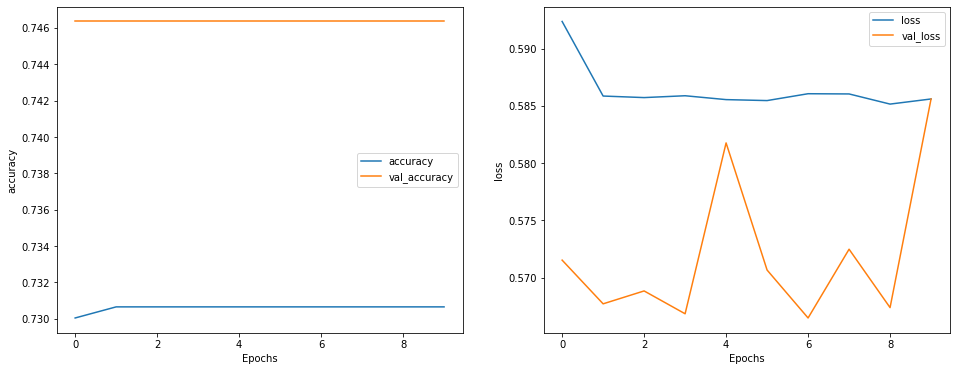

In [240]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyR1R, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyR1R, 'loss')

## sigmoid

In [241]:
modelSR = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [242]:
modelSR.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-1),
              metrics=['accuracy'])

In [243]:
historySR = modelSR.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 34s 34ms/step - loss: 0.6209 - accuracy: 0.7198 - val_loss: 0.5626 - val_accuracy: 0.7453
Epoch 2/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5734 - accuracy: 0.7322 - val_loss: 0.5793 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5732 - accuracy: 0.7323 - val_loss: 0.5500 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5758 - accuracy: 0.7310 - val_loss: 0.5704 - val_accuracy: 0.7526
Epoch 5/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5785 - accuracy: 0.7270 - val_loss: 0.5550 - val_accuracy: 0.7474
Epoch 6/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5772 - accuracy: 0.7287 - val_loss: 0.5606 - val_accuracy: 0.7427
Epoch 7/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5719 - accuracy: 0.7343 - val_loss: 0.5729 - val_accuracy:

In [244]:
test_loss, test_acc = modelSR.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.6008 - accuracy: 0.7335
Test Loss: 0.6008422374725342
Test Accuracy: 0.7334561944007874


In [245]:
from sklearn.metrics import classification_report
predict=np.around(modelSR.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7401    0.9814    0.8438      8758
           2     0.4969    0.0506    0.0919      3180

    accuracy                         0.7335     11938
   macro avg     0.6185    0.5160    0.4679     11938
weighted avg     0.6753    0.7335    0.6435     11938



In [246]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelSR.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


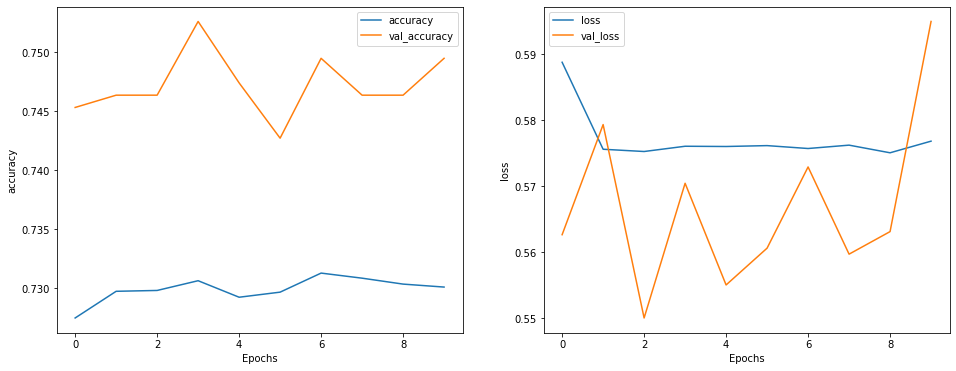

In [247]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historySR, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historySR, 'loss')

## tanh

In [248]:
modelT1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [249]:
modelT1.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-1),
              metrics=['accuracy'])

In [250]:
historyT1 = modelT1.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 32s 35ms/step - loss: 0.6288 - accuracy: 0.7078 - val_loss: 0.5774 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5909 - accuracy: 0.7289 - val_loss: 0.5691 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5866 - accuracy: 0.7296 - val_loss: 0.5738 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5913 - accuracy: 0.7278 - val_loss: 0.5739 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5845 - accuracy: 0.7339 - val_loss: 0.5734 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5882 - accuracy: 0.7305 - val_loss: 0.6056 - val_accuracy: 0.7406
Epoch 7/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5926 - accuracy: 0.7272 - val_loss: 0.5738 - val_accuracy:

In [251]:
test_loss, test_acc = modelT1.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.6108 - accuracy: 0.7336
Test Loss: 0.6107938289642334
Test Accuracy: 0.733623743057251


In [252]:
from sklearn.metrics import classification_report
predict=np.around(modelT1.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [253]:

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelT1.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


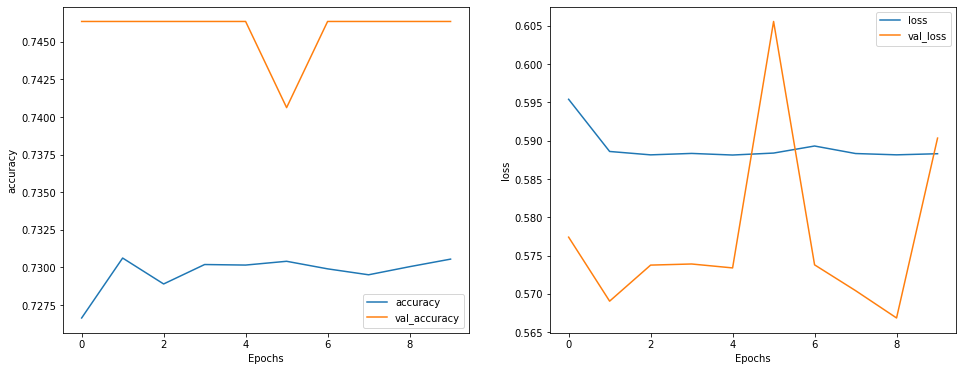

In [254]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyT1, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyT1, 'loss')

## Using GRU and Adam without dropoud layer before dense

### relu

In [361]:
modelRDGR = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(3)),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [362]:
modelRDGR.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-1),
              metrics=['accuracy'])

In [363]:
historyRDGR = modelRDGR.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 22s 33ms/step - loss: 0.6004 - accuracy: 0.7253 - val_loss: 0.5579 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5800 - accuracy: 0.7284 - val_loss: 0.5554 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5770 - accuracy: 0.7292 - val_loss: 0.5559 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 14s 31ms/step - loss: 0.5730 - accuracy: 0.7326 - val_loss: 0.5535 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5763 - accuracy: 0.7260 - val_loss: 0.5547 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 14s 31ms/step - loss: 0.5770 - accuracy: 0.7294 - val_loss: 0.5552 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 14s 31ms/step - loss: 0.5707 - accuracy: 0.7332 - val_loss: 0.5600 - val_accuracy:

In [364]:
test_loss, test_acc = modelRDGR.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 2s 8ms/step - loss: 0.5679 - accuracy: 0.7336
Test Loss: 0.5679048895835876
Test Accuracy: 0.733623743057251


In [365]:
from sklearn.metrics import classification_report
predict=np.around(modelRDGR.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [366]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelRDGR.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


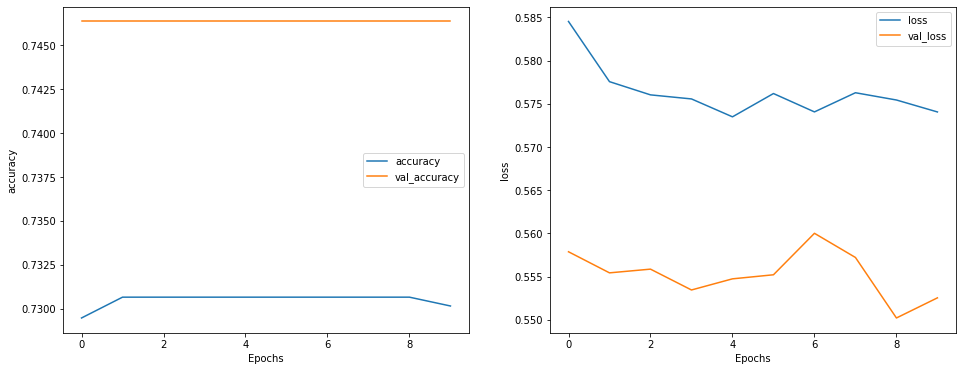

In [367]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyRDGR, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyRDGR, 'loss')

### sigmoid

In [370]:
modelSDMS = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(3)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [371]:
modelSDMS.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-1),
              metrics=['accuracy'])

In [372]:
historySDMS = modelSDMS.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 23s 33ms/step - loss: 0.5987 - accuracy: 0.7319 - val_loss: 0.5686 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5912 - accuracy: 0.7263 - val_loss: 0.5634 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 13s 31ms/step - loss: 0.5828 - accuracy: 0.7328 - val_loss: 0.5608 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 13s 31ms/step - loss: 0.5840 - accuracy: 0.7292 - val_loss: 0.5624 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 13s 31ms/step - loss: 0.5799 - accuracy: 0.7325 - val_loss: 0.5605 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5815 - accuracy: 0.7332 - val_loss: 0.5691 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 13s 30ms/step - loss: 0.5848 - accuracy: 0.7303 - val_loss: 0.5713 - val_accuracy:

In [374]:
test_loss, test_acc = modelSDMS.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 7ms/step - loss: 0.5816 - accuracy: 0.7336
Test Loss: 0.5816241502761841
Test Accuracy: 0.733623743057251


In [375]:
from sklearn.metrics import classification_report
predict=np.around(modelSDMS.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [376]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelSDMS.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


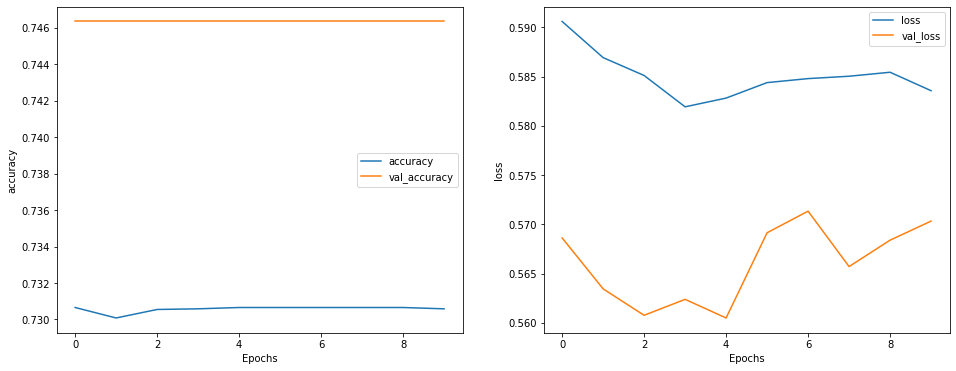

In [377]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historySDMS, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historySDMS, 'loss')

### tanh

In [255]:
modelTDMS = tf.keras.Sequential([
    encoder,
   tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [256]:
modelTDMS.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-1),
              metrics=['accuracy'])

In [257]:
historyTDMS = modelTDMS.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 34s 34ms/step - loss: 0.6105 - accuracy: 0.7168 - val_loss: 0.5840 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5816 - accuracy: 0.7317 - val_loss: 0.5696 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5836 - accuracy: 0.7288 - val_loss: 0.5706 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5819 - accuracy: 0.7306 - val_loss: 0.5588 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 10s 24ms/step - loss: 0.5797 - accuracy: 0.7290 - val_loss: 0.5661 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5831 - accuracy: 0.7282 - val_loss: 0.5671 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5793 - accuracy: 0.7308 - val_loss: 0.5650 - val_accuracy:

In [262]:
test_loss, test_acc = modelTDMS.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.5765 - accuracy: 0.7336
Test Loss: 0.5765401124954224
Test Accuracy: 0.733623743057251


In [259]:
from sklearn.metrics import classification_report
predict=np.around(modelTDMS.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [260]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelTDMS.predict(np.array([sample_text]))
print(predictions)

[[7.273602e-01 9.103866e-06 2.726307e-01]]


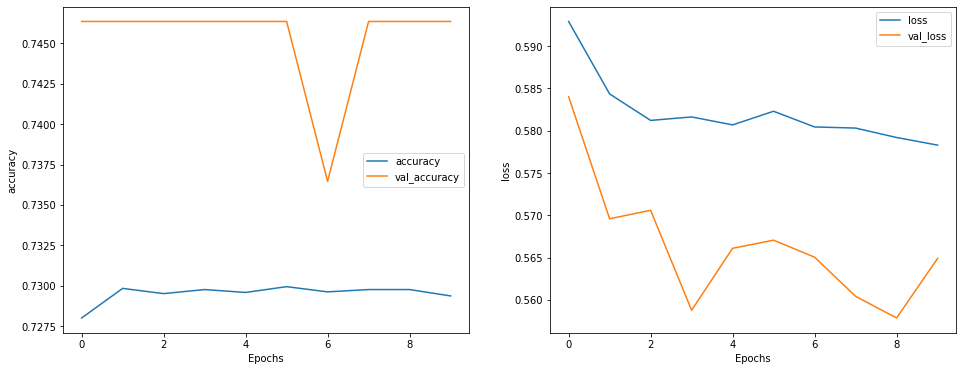

In [261]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyTDMS, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyTDMS, 'loss')

## Gru RMSprop

### relu

In [264]:
modelRDGR1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(3)),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [265]:
modelRDGR1.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-1),
              metrics=['accuracy'])

In [266]:
historyRDGR1 = modelRDGR1.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 18s 27ms/step - loss: 0.6146 - accuracy: 0.7308 - val_loss: 0.5777 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5837 - accuracy: 0.7309 - val_loss: 0.5607 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5837 - accuracy: 0.7284 - val_loss: 0.5836 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5846 - accuracy: 0.7323 - val_loss: 0.5911 - val_accuracy: 0.7464
Epoch 5/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5876 - accuracy: 0.7281 - val_loss: 0.5720 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5861 - accuracy: 0.7302 - val_loss: 0.5665 - val_accuracy: 0.7464
Epoch 7/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5845 - accuracy: 0.7321 - val_loss: 0.5741 - val_accuracy:

In [267]:
test_loss, test_acc = modelRDGR1.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.5874 - accuracy: 0.7336
Test Loss: 0.5873918533325195
Test Accuracy: 0.733623743057251


In [269]:
from sklearn.metrics import classification_report
predict=np.around(modelRDGR1.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [271]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelRDGR1.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


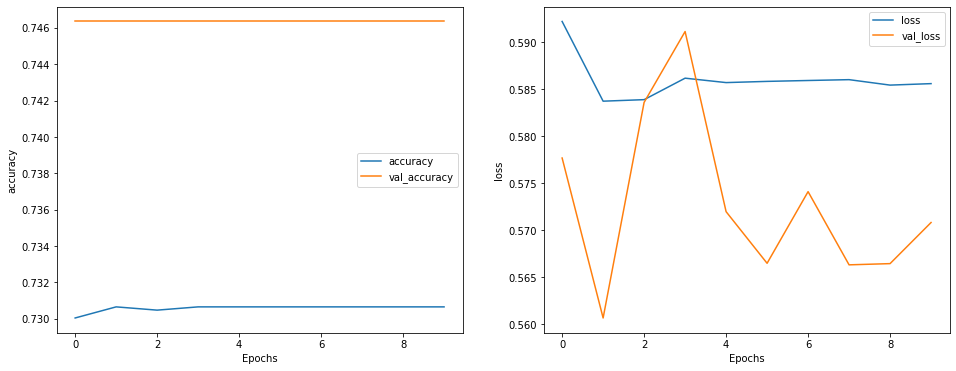

In [272]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyRDGR1, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyRDGR1, 'loss')

### sigmoid

In [273]:
modelSDMS1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(3)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [274]:
modelSDMS1.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-1),
              metrics=['accuracy'])

In [275]:
historySDMS1 = modelSDMS1.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 18s 27ms/step - loss: 0.5996 - accuracy: 0.7230 - val_loss: 0.5486 - val_accuracy: 0.7437
Epoch 2/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5768 - accuracy: 0.7253 - val_loss: 0.5541 - val_accuracy: 0.7448
Epoch 3/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5689 - accuracy: 0.7283 - val_loss: 0.5925 - val_accuracy: 0.7464
Epoch 4/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5682 - accuracy: 0.7300 - val_loss: 0.5678 - val_accuracy: 0.7484
Epoch 5/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5619 - accuracy: 0.7326 - val_loss: 0.5642 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5701 - accuracy: 0.7249 - val_loss: 0.5719 - val_accuracy: 0.7328
Epoch 7/10
436/436 [==============================] - 11s 26ms/step - loss: 0.5686 - accuracy: 0.7287 - val_loss: 0.5993 - val_accuracy:

In [276]:
test_loss, test_acc = modelSDMS1.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.6136 - accuracy: 0.7325
Test Loss: 0.6136431694030762
Test Accuracy: 0.7325347661972046


In [277]:
from sklearn.metrics import classification_report
predict=np.around(modelSDMS1.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7460    0.9633    0.8409      8758
           2     0.4897    0.0969    0.1617      3180

    accuracy                         0.7325     11938
   macro avg     0.6179    0.5301    0.5013     11938
weighted avg     0.6778    0.7325    0.6600     11938



In [278]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelSDMS1.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[0]


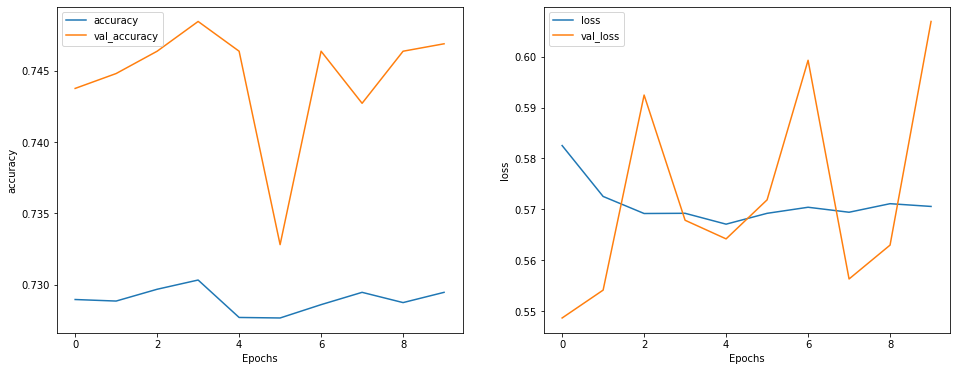

In [279]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historySDMS1, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historySDMS1, 'loss')

### tanh

In [280]:
modelTDMS1 = tf.keras.Sequential([
    encoder,
   tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 5, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [281]:
modelTDMS1.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-1),
              metrics=['accuracy'])

In [282]:
historyTDMS1 = modelTDMS1.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 32s 35ms/step - loss: 0.6089 - accuracy: 0.7158 - val_loss: 0.5934 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5762 - accuracy: 0.7244 - val_loss: 0.5743 - val_accuracy: 0.7464
Epoch 3/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5728 - accuracy: 0.7280 - val_loss: 0.5513 - val_accuracy: 0.7443
Epoch 4/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5724 - accuracy: 0.7287 - val_loss: 0.5513 - val_accuracy: 0.7505
Epoch 5/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5703 - accuracy: 0.7328 - val_loss: 0.5720 - val_accuracy: 0.7464
Epoch 6/10
436/436 [==============================] - 11s 25ms/step - loss: 0.5743 - accuracy: 0.7272 - val_loss: 0.6091 - val_accuracy: 0.7484
Epoch 7/10
436/436 [==============================] - 11s 24ms/step - loss: 0.5758 - accuracy: 0.7267 - val_loss: 0.5599 - val_accuracy:

In [283]:
test_loss, test_acc = modelTDMS1.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 1s 6ms/step - loss: 0.6726 - accuracy: 0.7336
Test Loss: 0.6726342439651489
Test Accuracy: 0.733623743057251


In [284]:
from sklearn.metrics import classification_report
predict=np.around(modelTDMS1.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))


              precision    recall  f1-score   support

           0     0.7336    1.0000    0.8463      8758
           2     0.0000    0.0000    0.0000      3180

    accuracy                         0.7336     11938
   macro avg     0.3668    0.5000    0.4232     11938
weighted avg     0.5382    0.7336    0.6209     11938



In [287]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelTDMS1.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))



[0]


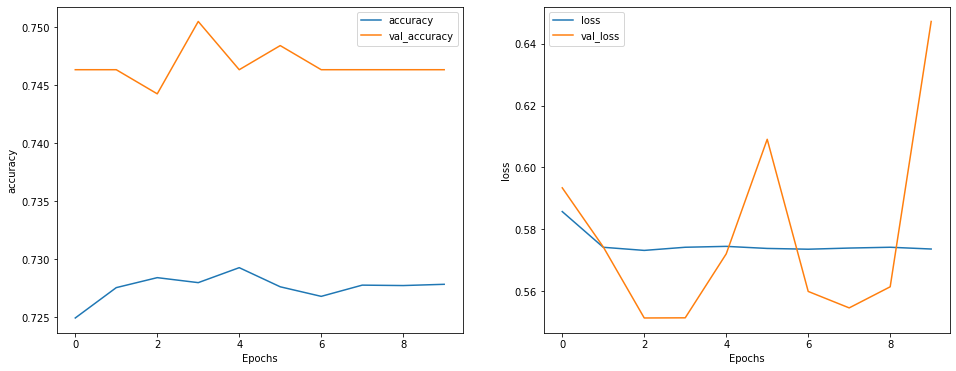

In [288]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyTDMS1, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyTDMS1, 'loss')

## Complex layers in RNN

In [450]:
# model = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dense(64, activation='sigmoid'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(3, activation='softmax')

# ])
# # model = tf.keras.Sequential([
# #     encoder,
# #     tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
# #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)),
# #     tf.keras.layers.Dropout(0.1),
# #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
# #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
# #     tf.keras.layers.Dense(32, activation='sigmoid'),
# #     tf.keras.layers.Dropout(0.5),
# #     tf.keras.layers.Dense(3, activation='softmax')

# # ])73.47
# model = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dense(64, activation='sigmoid'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(3, activation='softmax')

# ])73.50
# model = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)),
#     tf.keras.layers.Dropout(0.5),

#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,  return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
#     tf.keras.layers.Dense(16, activation='sigmoid'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(3, activation='softmax')

# ])73.7
# model = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,  return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8,  return_sequences=True)),
#         tf.keras.layers.Dense(16, activation='sigmoid'),


#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
#     tf.keras.layers.Dense(8, activation='sigmoid'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(3, activation='softmax')

# ])73.72
modelC = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8,  return_sequences=True)),
        tf.keras.layers.Dense(16, activation='sigmoid'),

 tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(8,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')

])

In [452]:
modelC.compile(loss='sparse_categorical_crossentropy',
              
              optimizer=tf.keras.optimizers.Adam(1e-2),
              #optimizer=tf.keras.optimizers.RMSprop(1e-2),
              
              metrics=['accuracy'])

In [453]:
historyC = modelC.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
436/436 [==============================] - 103s 139ms/step - loss: 0.6421 - accuracy: 0.7099 - val_loss: 0.5604 - val_accuracy: 0.7464
Epoch 2/10
436/436 [==============================] - 43s 99ms/step - loss: 0.5806 - accuracy: 0.7283 - val_loss: 0.5591 - val_accuracy: 0.7484
Epoch 3/10
436/436 [==============================] - 44s 101ms/step - loss: 0.5733 - accuracy: 0.7307 - val_loss: 0.5550 - val_accuracy: 0.7469
Epoch 4/10
436/436 [==============================] - 44s 102ms/step - loss: 0.5605 - accuracy: 0.7397 - val_loss: 0.5452 - val_accuracy: 0.7380
Epoch 5/10
436/436 [==============================] - 44s 101ms/step - loss: 0.5522 - accuracy: 0.7380 - val_loss: 0.5391 - val_accuracy: 0.7458
Epoch 6/10
436/436 [==============================] - 44s 100ms/step - loss: 0.5440 - accuracy: 0.7469 - val_loss: 0.5431 - val_accuracy: 0.7474
Epoch 7/10
436/436 [==============================] - 44s 101ms/step - loss: 0.5471 - accuracy: 0.7448 - val_loss: 0.5431 - val_ac

In [454]:
test_loss, test_acc = modelC.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

187/187 [==============================] - 4s 23ms/step - loss: 0.5599 - accuracy: 0.7368
Test Loss: 0.5598687529563904
Test Accuracy: 0.7368068099021912


In [455]:
from sklearn.metrics import classification_report
predict=np.around(modelC.predict(test_dataset_first.text),decimals=0).argmax(axis=1)
print(classification_report(np.array(test_dataset_first.label), predict, digits=4))

# print(classification_report(np.array(test_dataset_first.label),predict , digits=4)

              precision    recall  f1-score   support

           0     0.7421    0.9826    0.8456      8758
           2     0.5543    0.0594    0.1074      3180

    accuracy                         0.7367     11938
   macro avg     0.6482    0.5210    0.4765     11938
weighted avg     0.6921    0.7367    0.6489     11938



In [456]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelC.predict(np.array([sample_text]))
print(np.around(predictions,decimals=0).argmax(axis=1))


[[8.3297962e-01 3.4001900e-05 1.6698645e-01]]


In [457]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = modelC.predict(np.array([sample_text]))
print(predictions)

[[8.3297962e-01 3.4001900e-05 1.6698645e-01]]


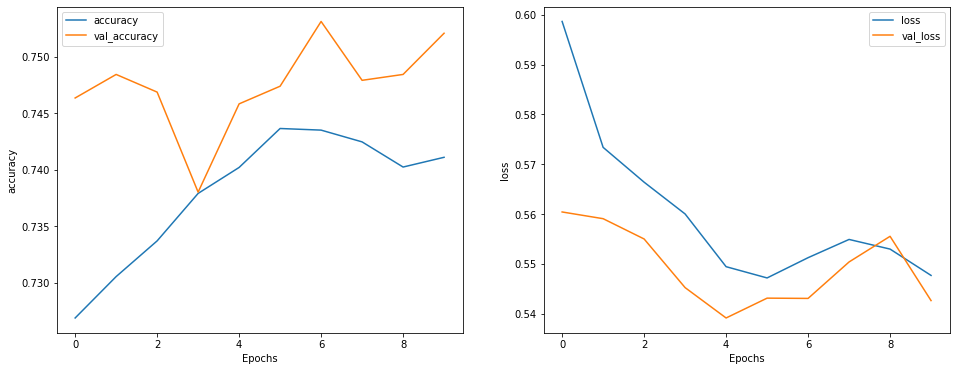

In [458]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyC, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyC, 'loss')

# Naive Bayes

In [289]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}

In [297]:
# X_train, X_test, y_train, y_test = train_test_split(df['text'][0:100], df['label'][0:100], test_size=0.33, random_state=2000)
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.33, random_state=2000)


In [298]:
from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=10)
clf.fit(x_train, y_train)

print(classification_report(y_test, clf.predict(x_test), digits=4))

              precision    recall  f1-score   support

           0     0.7318    0.9975    0.8443      9597
           2     0.5294    0.0076    0.0151      3535

    accuracy                         0.7310     13132
   macro avg     0.6306    0.5026    0.4297     13132
weighted avg     0.6773    0.7310    0.6210     13132



# Random forest


In [299]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = tfidfconverter.fit_transform(df['text']).toarray()

In [300]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.33, random_state=2000)

In [302]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
classifier = RandomForestClassifier(n_estimators=1000, random_state=2000)
classifier.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=2000,
                       verbose=0, warm_start=False)

In [303]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


print(classification_report(y_test, classifier.predict(X_test), digits=4))


              precision    recall  f1-score   support

           0     0.7566    0.9171    0.8291      9597
           2     0.4690    0.1989    0.2793      3535

    accuracy                         0.7237     13132
   macro avg     0.6128    0.5580    0.5542     13132
weighted avg     0.6791    0.7237    0.6811     13132

